<a href="https://colab.research.google.com/github/hungpham13/Laptop-EDA/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/hungpham13/Laptop-EDA/

Cloning into 'Laptop-EDA'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 299 (delta 178), reused 135 (delta 62), pack-reused 0
Receiving objects: 100% (299/299), 29.50 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (178/178), done.


# Welcome to Laptop Market Exploratory Data Analysis !
Here we are going to take a closer look at our Laptop data that was scraped from 3 main websites: fptshop.com.vn, cellphones.com and thegioididong.com.vn. 


---


In this section, we will be analysing our data in a variety of aspect: 
+ We will divide the analysis into 3 main sections: 
  + Import data and preprocessing
  + Examine Numerical Attributes, which focus on the distributions of importants attributes and determine the relationship with other numerical columns.
  + Examine Categorical Attributes, which focus on the categories distribution and chi-square test to determine if an attribute affects others.

**NOTE: REMOVE OUTLIER OF NUMERIC ATT**

## I. Import libraries, Data and prepare data


---

Our data preparing includes importing data, drop unnecessary columns, handle missing value and prepare numerical/categorical attributes.

### Import libraries
In our Analysis today, we will mostly use matplotlib and seaborn library for ploting data; scipy library is also needed for calculating entropy and chisquare statistics - we will see in the third section.

In [91]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import seaborn as sns
from matplotlib import cm
plt.style.use('ggplot')
cmap = cm.get_cmap('Spectral')

import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy import stats
from scipy.stats import chi2_contingency, entropy, chi2

### Import and explore the data
File name: `merged_data.csv`

Here we notice that the original indexes from scraped data are not useful anymore, so we should drop them. Without dropping those columns, our data later on wil have noise in calculating correlation as well as numerical attributes analysis.

In [3]:
source_data = pd.read_csv('./Laptop-EDA/merged_data.csv')
to_drop = ['Index_fpt','Index_cellphones','Index_tgdd','Unnamed: 0','P/N','Series']
main_data = source_data.drop(to_drop, axis = 1)
main_data.head()

,GPU,Comment_count,Price,Rating,Rating_count,Brand,cpu_brand,cpu_code,ram_size,storage_size,displ_size,displ_rate,Battery,OS,displ_resolution,hdmi,Release_year,Surface,Weight,backlit_keyboard,lan,length,ram_upgradable,screen_technology,sd_card,storage_extra_slot,storage_type,headphone_jack,thickness,type_c,usb_a,width,Availabe_in,GPU_brand
0,nvidia geforce rtx 3050 ti,906.0,2.862633e+07,NaN,0.0,acer,intel,11800h,8.0,512.0,15.6,144.0,57.0,windows 10,1920 x 1080,yes,2021.0,plastic,2.20,yes,yes,363.40,yes,ips,no,yes,ssd,yes,23.9,yes,yes,255.00,3,nvidia
1,nvidia geforce mx450,400.0,2.125967e+07,NaN,0.0,msi,intel,1155g7,8.0,512.0,14.0,60.0,39.0,windows 10,1920 x 1080,yes,2021.0,metal,1.30,yes,no,319.00,yes,ips,yes,no,ssd,yes,16.9,yes,yes,219.00,3,nvidia
2,intel uhd graphics,322.0,1.529450e+07,3.7,18.0,dell,intel,1115g4,4.0,256.0,15.6,60.0,41.0,windows 10,1920 x 1080,yes,2021.0,plastic,1.70,no,no,358.50,yes,va,yes,yes,ssd,yes,18.9,no,yes,235.50,2,intel
3,intel uhd graphics,378.0,1.499900e+07,5.0,4.0,lenovo,intel,1115g4,8.0,512.0,15.6,60.0,NaN,windows 10,1920 x 1080,yes,2021.0,plastic,1.65,yes,yes,359.00,yes,led,yes,yes,ssd,yes,19.9,yes,yes,237.70,1,intel
4,intel iris xe graphics,1244.0,1.879900e+07,5.0,5.0,lenovo,intel,1135g7,16.0,512.0,15.6,60.0,45.0,windows 10,1920 x 1080,yes,2021.0,"metal, plastic",1.66,yes,yes,356.67,yes,ips,yes,yes,ssd,yes,17.9,yes,yes,233.13,1,intel


In [4]:
print(main_data.shape)
print(main_data.info())

(552, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   GPU                 548 non-null    object 
 1   Comment_count       552 non-null    float64
 2   Price               496 non-null    float64
 3   Rating              168 non-null    float64
 4   Rating_count        552 non-null    float64
 5   Brand               552 non-null    object 
 6   cpu_brand           552 non-null    object 
 7   cpu_code            552 non-null    object 
 8   ram_size            552 non-null    float64
 9   storage_size        552 non-null    float64
 10  displ_size          552 non-null    float64
 11  displ_rate          552 non-null    float64
 12  Battery             489 non-null    float64
 13  OS                  548 non-null    object 
 14  displ_resolution    545 non-null    object 
 15  hdmi                548 non-null    object 
 16

This dataset contains 552 rows and 34 columns.

Here, I will explain the meaning of each columns:

+ The most important attributes to follow along is `Comment_count` (total number of comments on each product, summarized from all 3 sources), `Rating` (Rating score on scale 5 for each laptop) and the last one is `Rating_count` (number of feedback given on each laptop).
  + `Comment_count` represents the crowd attention or popularity of a product.
  + `Rating` and `Rating_count` represent how good or bad the product is, or how satisfactory customer feels with that product. 
+ `Price`: the sale price of each laptop in Vietnamese currency (VND)
+ `Brand` and `Series`: Name of laptop's brand and its particular model name 
+ `cpu_brand` and `cpu_code`: Name of CPU's manufacturer and the CPU model number
- Ram specs (2 variables)
    - `ram_size` (GB)
    - `ram_upgradable`: has extra slot to expand ram capacity or not
- Storage specs (3 variables)
    - `storage_size`: storage capacity of laptop's hard drive (GB)
    - `storage_type`: hard drive type (SSD, HDD, eMMC)
    - `storage_extra_slot`: has extra slot to expand storage capacity or not
- Display specs (4 variables)
    - `displ_size`: display size (inch)
    - `displ_resolution`: display resolution (1920 x 1080, 2560 x 1600,...)
    - `displ_rate`: display refresh rate (Hz)
    - `screen_technology`: panel type (IPS, VA, OLED,..)
- Size and Weight of the product (4 variables)
    - `Weight` (kg)
    - `length`, `width`, `thickness` (mm)		
- `GPU`: main graphics card (integrated or discrete)
- `Battery`: battery capacity (Wh)
- `OS`: Operating system pre-installed on the device
- `Surface`: Material of the case (plastic, aluminum, carbon,...)
- `Release_year`: Release year of the laptop
<!-- + For more precise look and better insights, we will need to examine some other attributes ralated to the technological details of our products such as: -->
- Ports and special features (7 variables)
    - `hdmi`: has hdmi socket or not
    - `headphone_jack`: has 3.5mm headphone plug or not
    - `lan`: has ethernet lan port or not
    - `type_c`: has USB Type-C socket or not
    - `usb_a`: has USB socket or not
    - `sd_card`: has sd card socket or not 
    - `backlit_keyboard`: whether the keyboard have backlight under the keys or not

### Normalize `Rating_count` and `Comment_count`

In [5]:
main_data['Comment_count'] = main_data['Comment_count']/main_data['Availabe_in']
main_data['Rating_count'] = main_data['Rating_count']/main_data['Availabe_in']
main_data = main_data.drop('Availabe_in',axis=1)

### Identify cagetorical and numeric variables

In [6]:
def add_number(ax,orient='h'):
    if orient == 'h':
        for p in ax.patches:
            # plt.text(x = , y = p.get_y() + 0.55 * p.get_height(), s = f'{int(p.get_width())}')
            ax.annotate(f"{float(p.get_width()):.1f}",
                            xy = (p.get_width(), p.get_y() + 0.5*p.get_height()), 
                             va = 'center', 
                            xytext = (5, 0), 
                            textcoords = 'offset points')
    elif orient == 'v':
        for p in ax.patches:
            ax.annotate(f"{float(p.get_height()):.1f}", 
                            xy = (p.get_x() + p.get_width() /2, p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 8), 
                            textcoords = 'offset points')

In [7]:
numeric_attributes = main_data[[c for c in main_data.columns 
                                # if main_data[c].value_counts().count() > 20
                                if is_numeric_dtype(main_data[c])]]
categorical_attributes = main_data[[c for c in main_data.columns if c not in numeric_attributes.columns]]

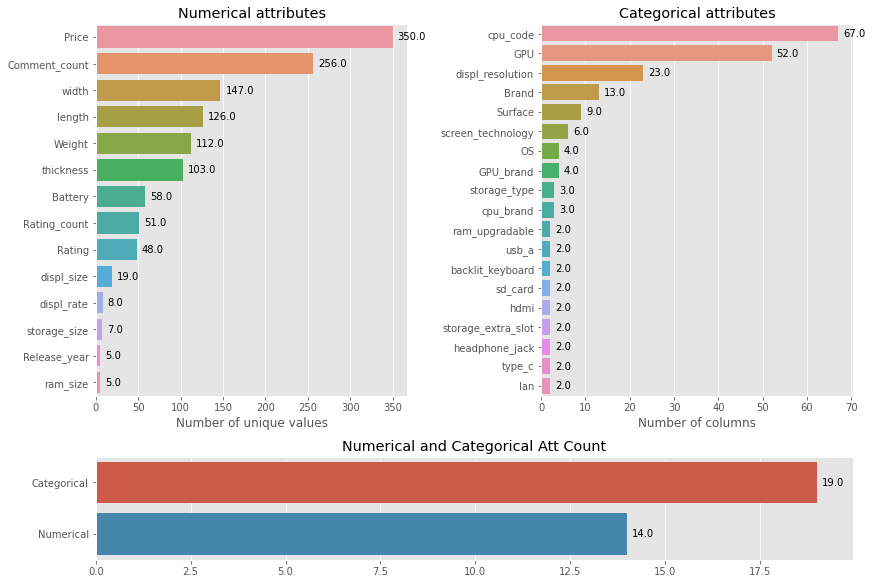

<Figure size 360x432 with 0 Axes>

In [8]:
fig = plt.figure(constrained_layout=True,figsize=(12,8))
gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0:2,0])
ax1 = fig.add_subplot(gs[0:2,1])
ax2 = fig.add_subplot(gs[2,:])

numeric_unique = numeric_attributes.nunique().sort_values(ascending=False)
sns.barplot(y=numeric_unique.index,x=numeric_unique.values,ax=ax0)
ax0.set_title('Numerical attributes')
ax0.set_xlabel('Number of unique values')
add_number(ax0)

cate_unique = categorical_attributes.nunique().sort_values(ascending=False)
sns.barplot(y=cate_unique.index,x=cate_unique.values,ax=ax1)
ax1.set_title('Categorical attributes')
ax1.set_xlabel('Number of unique values')
add_number(ax1)

fig = plt.figure(figsize=(5,6))
y = [len(categorical_attributes.columns), len(numeric_attributes.columns)]
sns.barplot(y=['Categorical', 'Numerical'],x= y,ax=ax2)
ax2.set_title('Numerical and Categorical Att Count')
ax1.set_xlabel('Number of columns')
add_number(ax2)


### Fill null
After checking the information of the remaining data, there are a lot of columns that still have null value. To handle this, we might choose either to drop all the missing row or to fill in the null values with appropriate value. 

Since our data is quite small in size, dropping all rows with null value is wasting information so filling in the missing value should be considered. For numerical attributes, we fill null by the mean of that columns. For categorical attributes, we simply replace null with "NaN"

Text(0, 0.5, 'Columns')

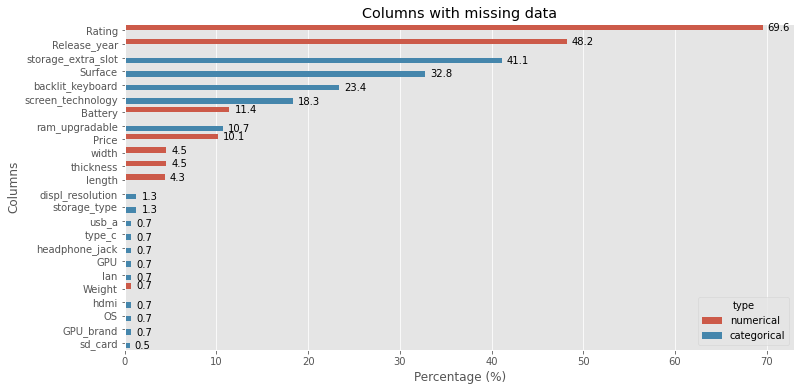

In [9]:
null_list = [[c,main_data[c].isnull().sum(axis=0)/len(main_data)*100] for c in main_data.columns 
             if main_data[c].isnull().sum(axis=0) != 0]
df_null = pd.DataFrame.from_records(null_list, columns=['col','missing_percent'])
df_null = df_null.sort_values('missing_percent',axis=0, ascending = False)
df_null['type'] = np.where(df_null.col.str.contains('|'.join(categorical_attributes.columns)), 'categorical','numerical')
# print(df_null)

plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_null, y='col', x='missing_percent', hue='type')
add_number(ax,orient='h')
# plt.xticks(rotation = 45,ha='right')
plt.title('Columns with missing data')
plt.xlabel('Percentage (%)')
plt.ylabel('Columns')

In [10]:
# for att in numeric_attributes.columns:
#     main_data[att].fillna(main_data[att].mean(), inplace = True)
for att in categorical_attributes.columns:
    main_data[att].fillna('NaN', inplace = True)

### Detect outliers
In this part, we will use Z-score function defined in scipy library to detect the outliers. The threshold for detection is 3

In [12]:
col_to_detect = ['Weight','length','thickness','width']
df_to_detect = numeric_attributes[col_to_detect].dropna()
# with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):
df_to_detect[(np.abs(stats.zscore(df_to_detect)) > 3)].append(df_to_detect[df_to_detect.Weight == 0]).join(source_data[['Series','Index_fpt','Index_tgdd','Index_cellphones']])

,Weight,length,thickness,width,Series,Index_fpt,Index_tgdd,Index_cellphones
153,0.775,201.0,292.0,8.5,surface pro 7 core 2019,75.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
153,0.775,201.0,292.0,8.5,surface pro 7 core 2019,75.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
153,0.775,201.0,292.0,8.5,surface pro 7 core 2019,75.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
158,0.775,201.0,292.0,8.5,surface pro 7 2019,93.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
158,0.775,201.0,292.0,8.5,surface pro 7 2019,93.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
158,0.775,201.0,292.0,8.5,surface pro 7 2019,93.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
159,0.775,201.0,292.0,8.5,surface pro 7 2019,106.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
159,0.775,201.0,292.0,8.5,surface pro 7 2019,106.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
159,0.775,201.0,292.0,8.5,surface pro 7 2019,106.0,NaN,https://cellphones.com.vn/surface-laptop-pro-7...
162,1.810,361.4,199.0,249.0,vostro v3500 7g3982,114.0,NaN,https://cellphones.com.vn/laptop-dell-vostro-1...


## II. Numeric attributes analysis

---


For numerical attributes, the first thing to pay attention is the distribution of that attributes, and the distribution among multiple attributes. From there, we can explore and come up with deep insight of our data. In this section, we will plot out some statistics of the most important properties to know better about our data's balance, relation and deduce some conclusion.

The visualization 
- For distribution of continuous variables: box plot and histogram
- For distribution of discrete numeric variables: bar plot
- For correlation between variables: heatmap

In [13]:
def plot_statistics(df: pd.DataFrame, bins = 50, title = None,discrete=False):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex= True, gridspec_kw={"height_ratios": (.15, .85)})
    fig.set_figheight(5)
    fig.set_figwidth(7)
    ax_box.set_title(title)
    if not discrete:
        sns.boxplot(df, ax=ax_box, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
        sns.distplot(df, ax=ax_hist, bins = bins)
        ax_box.get_xaxis().set_visible(False)
        sns.despine(ax=ax_box, left=True)
        ax_box.set_xlabel('')
    else:
        sns.countplot(df.sort_values(),ax=ax_hist)
    sns.despine(ax=ax_hist)


Firstly, we will head up to the analysis of our 3 most important variables: `Comment_count`, `Rating`, `Rating_count`

### `Comment_count`, `Rating` and `Rating_count`

With our 3 primary attributes of concern, distribution of each feature is also needed along with the statistics information.

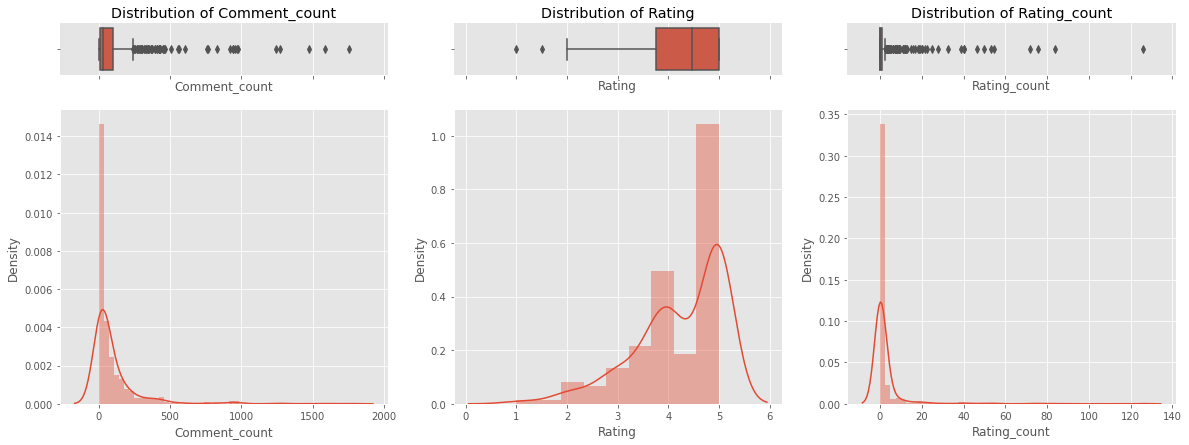

In [14]:
primary_attributes = main_data[['Comment_count','Rating','Rating_count']]
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20,7),sharex='col',gridspec_kw={"height_ratios": (.15, .85)})
for i, att in enumerate(primary_attributes.columns):
    sns.boxplot(primary_attributes[att], ax=ax[0,i])
    sns.distplot(primary_attributes[att], ax = ax[1,i])
    sns.despine(ax=ax[1,i])
    sns.despine(ax=ax[0,i], left=True)
    ax[0,i].set_title('Distribution of '+att)

Taken the very first look at the Density plot of 3 above features, it can be seen clearly that these features are significantly imbalance. The maximum values of *Comment_count* and *Rating_count* lies far beyond the center distribution and almost remain values is 0.

We will examine the statistical information of each attributes and histogram plot to get a better look.

The first attributes is *Comment_count*:

count     552.000000
mean      102.116244
std       197.811320
min         0.000000
25%        11.000000
50%        33.000000
75%       104.250000
max      1756.000000
Name: Comment_count, dtype: float64


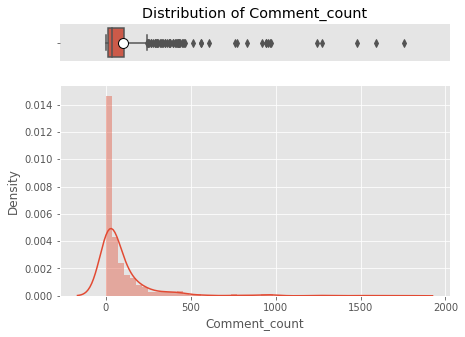

In [15]:
print(main_data.Comment_count.describe())
plot_statistics(main_data.Comment_count, title = 'Distribution of Comment_count')

The distribution has the shape of exponential distribution, with most of the values lie on 0 to 104 comments (75% quantile). However, there are some laptops have extremely high number of comments (up to 1756), which is very interesting for further analysis.
<!-- Checking that outliers might be useful for enhancing sale experience, but not really help in general analysis, so we will head to the next attributes `Rating`. -->

count    552.000000
mean       2.551932
std        9.917868
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      126.000000
Name: Rating_count, dtype: float64


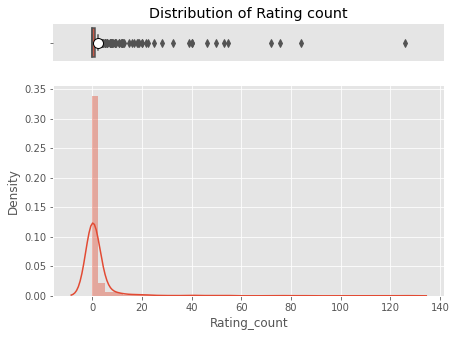

In [16]:
print(main_data.Rating_count.describe())
plot_statistics(main_data.Rating_count, title = 'Distribution of Rating count')

The Rating_count distribution makes us really confused. The zero value dominates the distribution, with more than 75% interval of 0 to 1. In other words, more than half of the products have not been rated. This will be a challenge for us to use it as a response variable and find its link with other attributes. Beside of that, as the distribution shape of this variable is very similar to `Comment_count`, we will examine their relationship in the next section.

In [17]:
# Try to divide the dataset to low and high rating count
low_rating_count = main_data[main_data.Rating_count <= main_data.Rating_count.mean()]
print(len(low_rating_count))
high_rating_count = main_data[main_data.Rating_count > main_data.Rating_count.mean()]
print(len(high_rating_count))

471
81


As the length of `high_rating_count` is too small, we would not go further into the analysis based on the division of dataset with Rating_count.

---



count    168.000000
mean       4.224201
std        0.880984
min        1.000000
25%        3.765000
50%        4.464286
75%        5.000000
max        5.000000
Name: Rating, dtype: float64


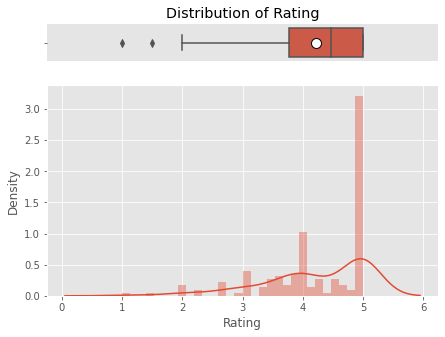

In [18]:
print(main_data.Rating.describe())
plot_statistics(main_data.Rating, bins= 30,title = 'Distribution of Rating')

The distribution of Rating has 2 peaks, with a clear mode 5 and another smaller mode 4. Most of the value are ranging between 3.7 and 5 stars, pointed out that  the overall Rating in our dataset is very positive. 
As mentioned in the previous section, the number of null values in Rating is nearly 70%. So we should notice that this distribution of Rating is just based on 30% of product that are rated in the dataset.

Our first concern focuses on numeric attributes. Because the number of numerical attributes is quite large, we would first look at the Pearson and Spearman correlation matrix to get an overview of the relationship between them

Text(0.5, 1.0, 'Pearson correlation matrix of numerical attributes')

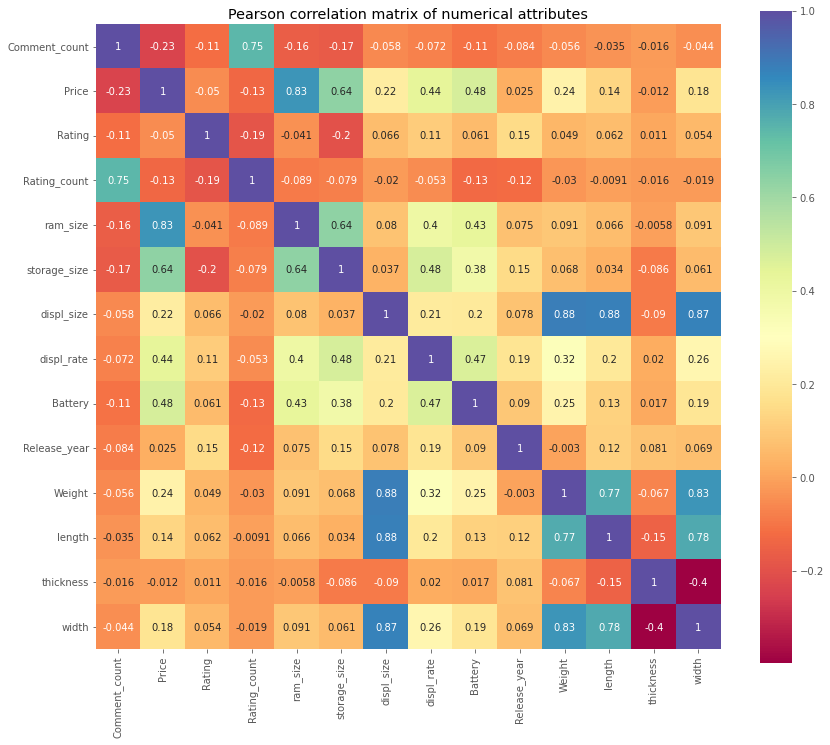

In [19]:
normalized_numeric_attributes = (numeric_attributes - numeric_attributes.mean())/numeric_attributes.std()
correlation = normalized_numeric_attributes.corr()
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(correlation, cmap=cmap, square = True, annot = True)
plt.title("Pearson correlation matrix of numerical attributes")

Text(0.5, 1.0, 'Spearman correlation matrix of numerical attributes')

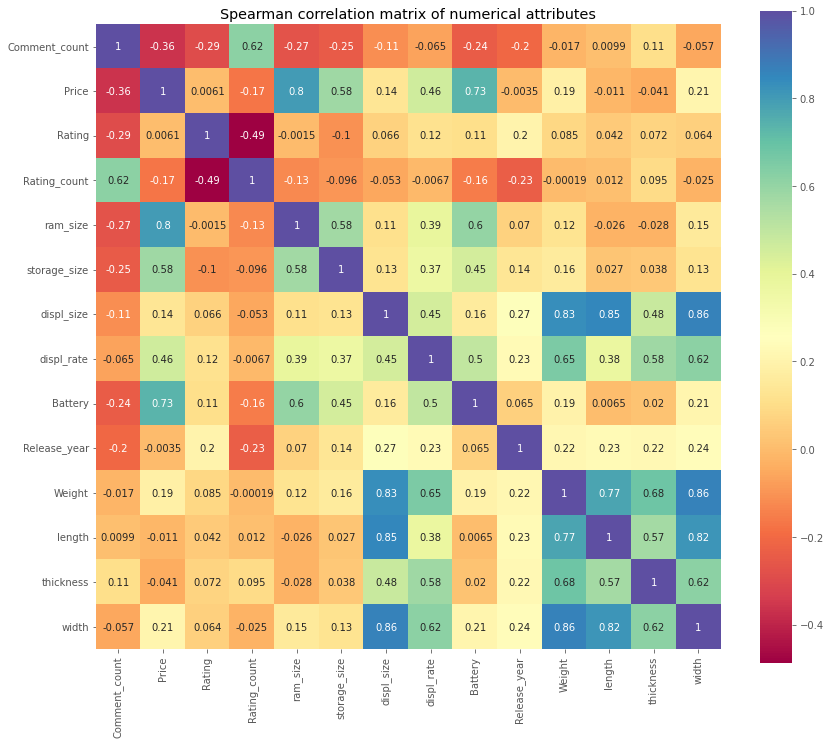

In [20]:
normalized_numeric_attributes = (numeric_attributes - numeric_attributes.mean())/numeric_attributes.std()
correlation = normalized_numeric_attributes.corr(method='spearman')
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(correlation, cmap=cmap, square = True, annot = True)
plt.title("Spearman correlation matrix of numerical attributes")

By observing the pearson coefficient and spearman coefficient in 2 matrix, we can conclude some relationships as folow:
- The rating count and the comment count are highly depended with each other, with the pearson coefficient = 0.75
- Display size influence a lots the size and weight of laptop, which is easy to understand
- Price is dependent on ram_size, storage size and battery capacity
- Ram size is dependent on storage size

Except Rating count, the relationship of all numerical attributes with Comment count is quite dubious. May be the correlation are exist in the form of 2 by 1 variables, which we will examine further in the next section.

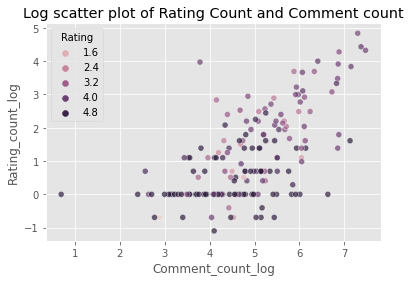

In [21]:
main_data['Comment_count_log'] = np.log(main_data['Comment_count'])
main_data['Rating_count_log'] = np.log(main_data['Rating_count'])
sns.scatterplot(x='Comment_count_log',y='Rating_count_log',hue='Rating',data=main_data,
                alpha=0.7)
plt.title("Log scatter plot of Rating Count and Comment count")
plt.show()

As being derived from the pearson matrix, the Comment_count and Rating_count are highly covariate to each other. This is clearly shown in this scatter plot, with the covariate is unbalanced. The number of product with low Rating_count and high Comment_count is higher than number of product with low Comment_count and high Rating_count.

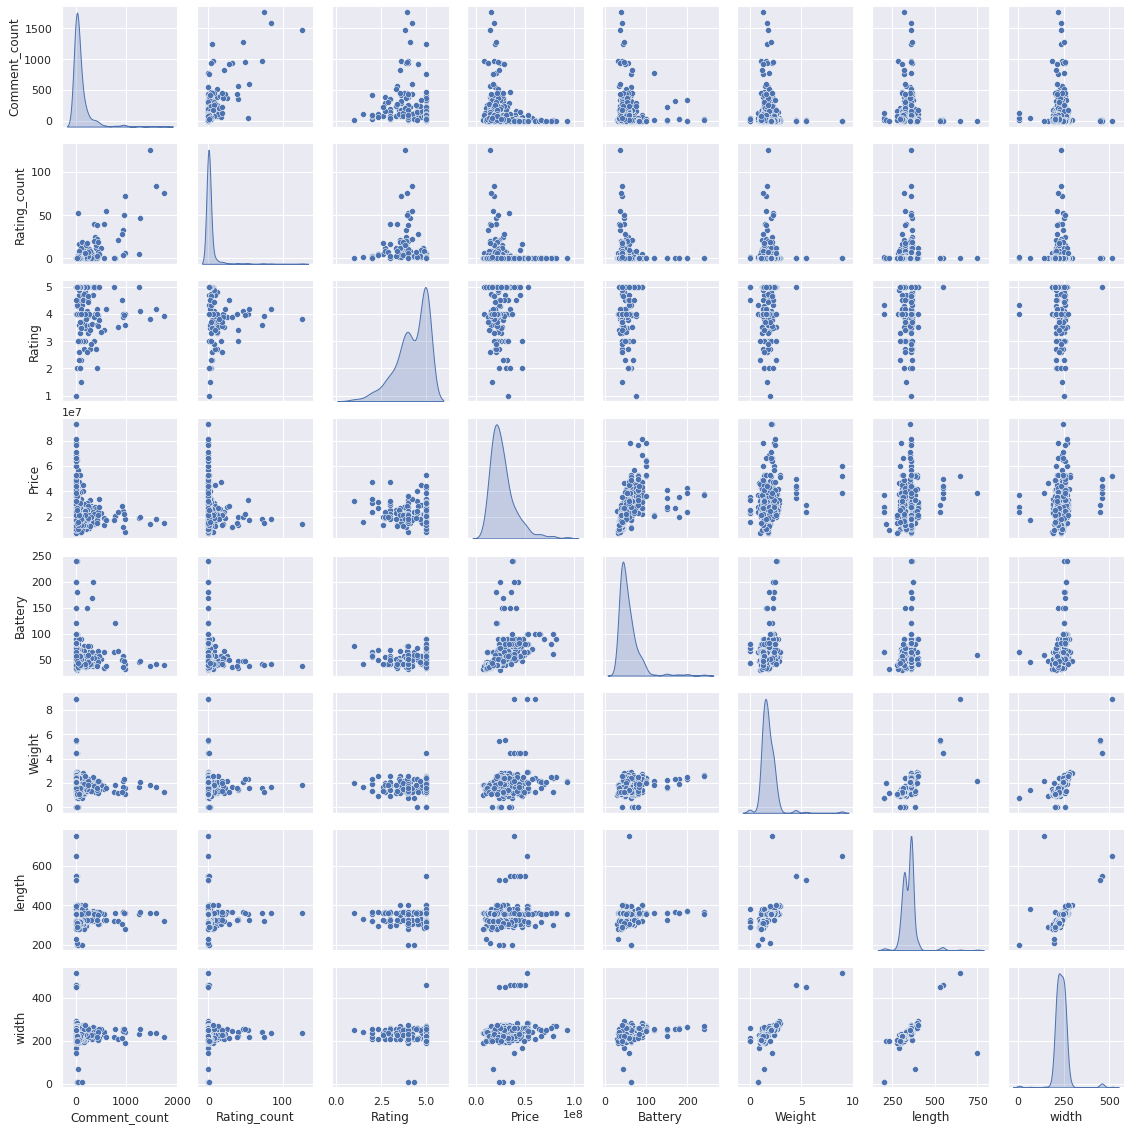

In [22]:
sns.set()
cols = ['Comment_count','Rating_count', 'Rating', 'Price', 'Battery', 'Weight', 'length', 'width']
# cols = numeric_attributes.columns
# print(cols)
sns.pairplot(main_data[cols],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

### `Price`

count    4.960000e+02
mean     2.675048e+07
std      1.294145e+07
min      7.290000e+06
25%      1.826575e+07
50%      2.363542e+07
75%      3.154088e+07
max      9.299000e+07
Name: Price, dtype: float64


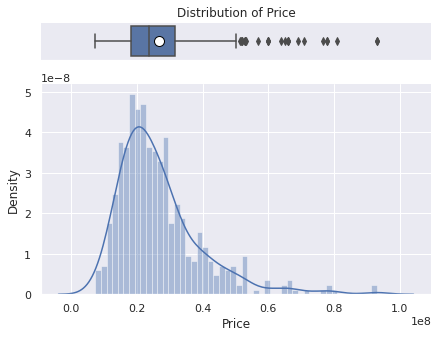

In [23]:
#Summarize some statistics information of Price and plot the distribution
print(main_data['Price'].describe())
#kurtosis and 
plot_statistics(main_data['Price'],title='Distribution of Price')

The distribution of `Price` is a bell curve, skewed right, centered around 26.000.000 VND and have standard variation of 12.000.000 VND.
The majority of our data focus on mid range laptop, with most common values lies between 18.000.000 to 30.000.000 VND. (~ 1000 - 1500 USD). 

The lowest price to afford a laptop from those sites is 7.000.000 VND (~ 350 USD) and the most luxury laptop costs ~ 93.000.000 VND (~ 4500 USD)

For further exploration, we will divide the price to different segments by the prior knowledge about the market:
- Low price range: smaller than 10.000.000 VND
- Low-middle price range: between 10.000.000 and 20.000.000
- Middle price range: between 20.000.000 and 30.000.000
- High-middle price range: between 30.000.000 and 40.000.000
- High price range: between 40.000.000 and 50.000.000
- Ultra high price range: higher than 50.000.000

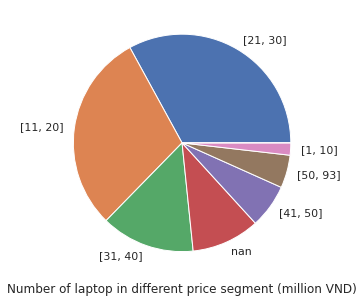

In [24]:
# low_price = main_data['Price'] <= 15000000
# avr_price = (main_data['Price'] > 15000000) & (main_data['Price'] <= 30000000)
# high_price = main_data['Price'] > 30000000
# main_data['price_segment'] = np.select([low_price, avr_price, high_price],['low','avr','high'], default=np.nan)
# print('low_price:  {} \navr_price:  {} \nhigh_price: {}'.format(len(low_price), len(avr_price), len(high_price)))

range_lower = list(range(-10, 60, 10))
range_upper = list(range(0, 60, 10))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))
range_lower.append(93)
labels.append(str([50,93]))

main_data['Price_range'] = pd.cut(main_data["Price"],
       bins=[i*1000000 for i in range_lower], 
       labels=labels)
main_data['Price_range'].value_counts(dropna=False).plot(kind='pie',figsize=(7,5),ylabel="")
plt.xlabel("Number of laptop in different price segment (million VND)")
# plt.ylabel("Price range (million VND)")
plt.show()

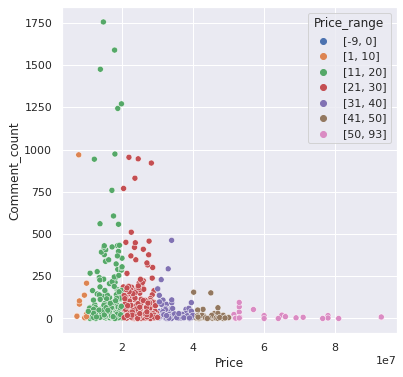

In [25]:
plt.subplots(figsize=(6, 6))
sns.scatterplot(x='Price', y='Comment_count', data=main_data, hue='Price_range')
# plt.ylim([0,400])
plt.show()

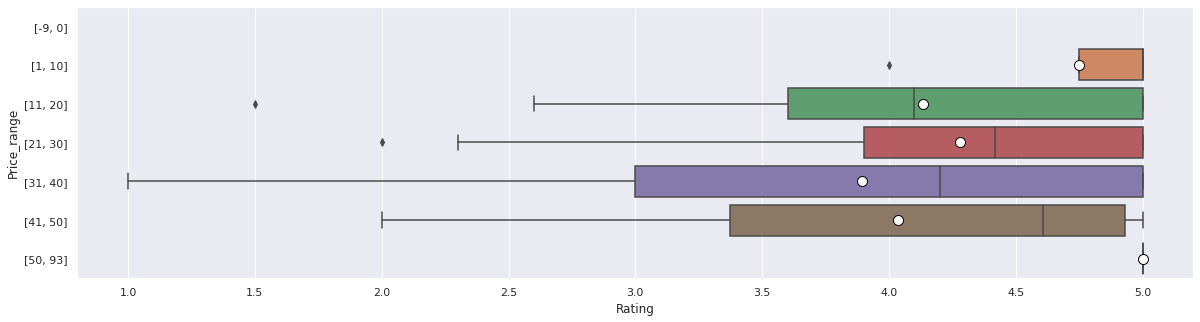

In [26]:
plt.subplots(figsize=(20, 5))
sns.boxplot(x='Rating', y='Price_range', data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
# plt.xlim([0,40])
plt.show()

Question: In the same price range, what factors make a product really standout?

To answer this question, we will plot out the correlation heat map and chi square coefficient in 3 most common price range: [11-20], [21-30] and [31-40]
- correlation of 3 respond variables with numeric attributes in different price range

In [27]:
price_df = [numeric_attributes[main_data['Price_range'] == c] for c in main_data['Price_range'].dropna().unique()]
labels = [c for c in main_data['Price_range'].dropna().unique()]
print(labels)
price_df[0]

['[21, 30]', '[11, 20]', '[31, 40]', '[41, 50]', '[50, 93]', '[1, 10]']


,Comment_count,Price,Rating,Rating_count,ram_size,storage_size,displ_size,displ_rate,Battery,Release_year,Weight,length,thickness,width
0,302.000000,2.862633e+07,NaN,0.0,8.0,512.0,15.6,144.0,57.0,2021.0,2.20,363.40,23.90,255.00
1,133.333333,2.125967e+07,NaN,0.0,8.0,512.0,14.0,60.0,39.0,2021.0,1.30,319.00,16.90,219.00
11,421.000000,2.349900e+07,2.0,3.0,16.0,512.0,14.0,60.0,65.0,2021.0,1.36,320.50,14.90,208.50
12,57.000000,2.699900e+07,NaN,0.0,8.0,512.0,15.6,120.0,45.0,2021.0,2.25,359.00,24.40,252.00
16,223.000000,2.599900e+07,NaN,0.0,8.0,512.0,14.0,144.0,150.0,2021.0,1.60,324.00,17.90,222.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,6.000000,2.999000e+07,NaN,0.0,8.0,512.0,14.0,60.0,52.0,NaN,1.29,319.00,15.90,219.00
546,23.000000,2.699000e+07,NaN,0.0,8.0,256.0,13.5,60.0,NaN,NaN,1.20,308.00,14.50,223.00
547,39.000000,2.699000e+07,NaN,0.0,8.0,256.0,13.5,60.0,47.0,NaN,1.27,308.00,14.50,223.00
549,76.000000,2.159000e+07,NaN,0.0,8.0,256.0,12.4,60.0,NaN,NaN,1.11,278.18,15.69,205.67


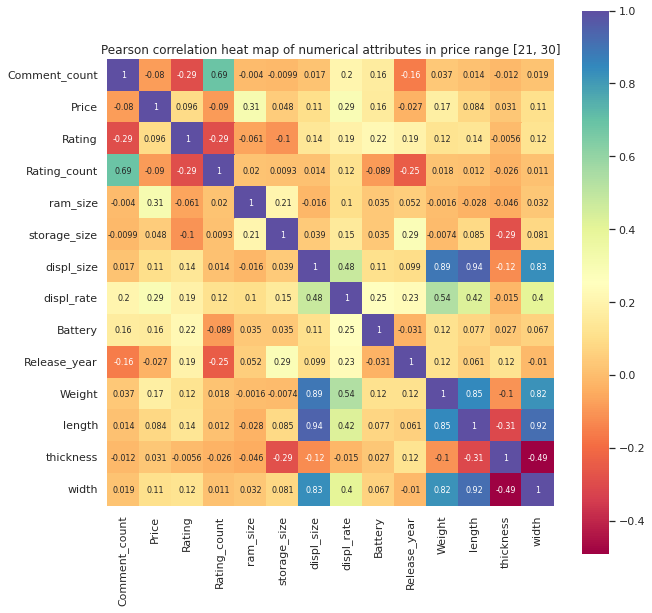

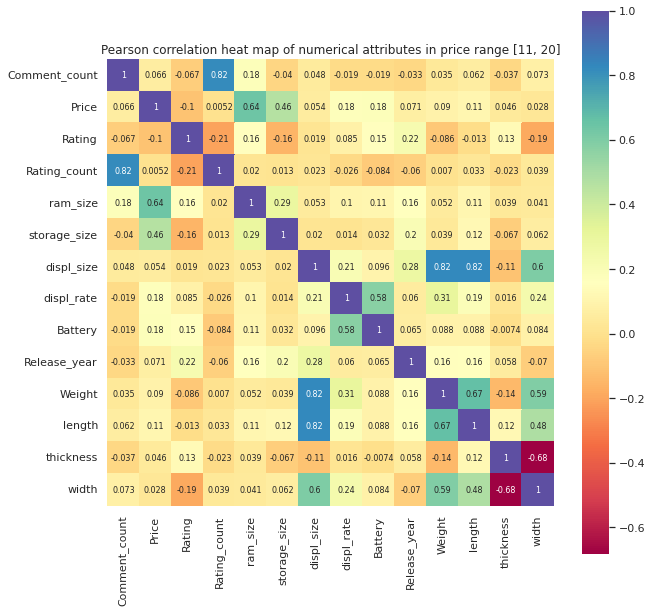

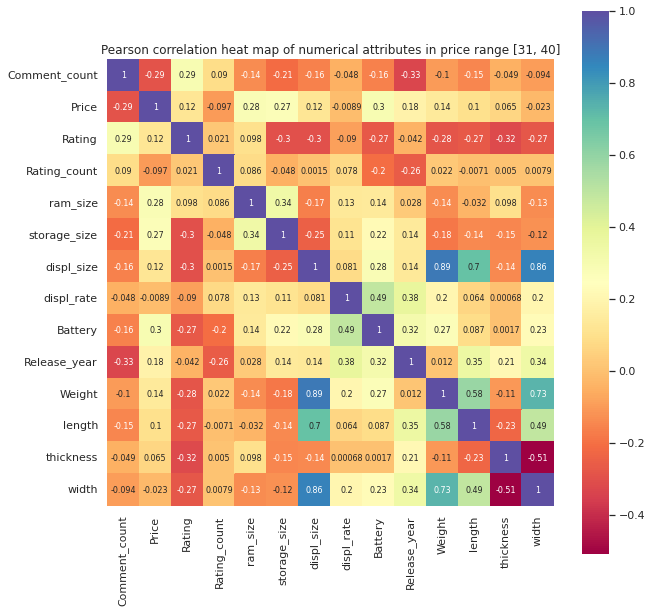

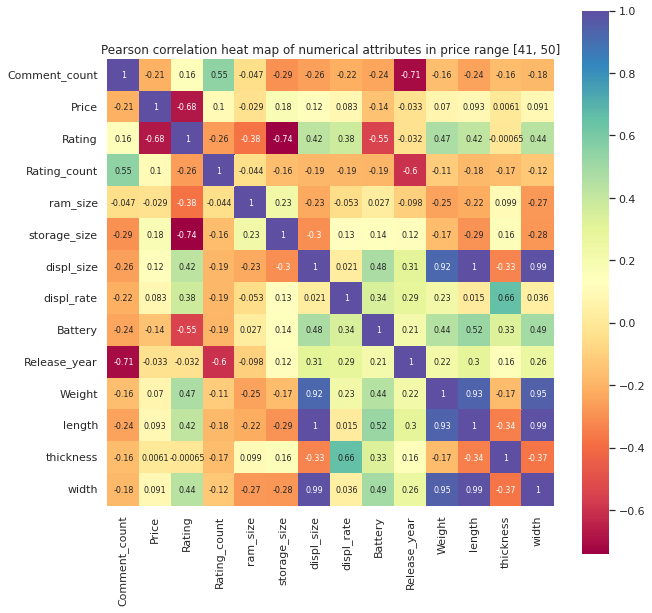

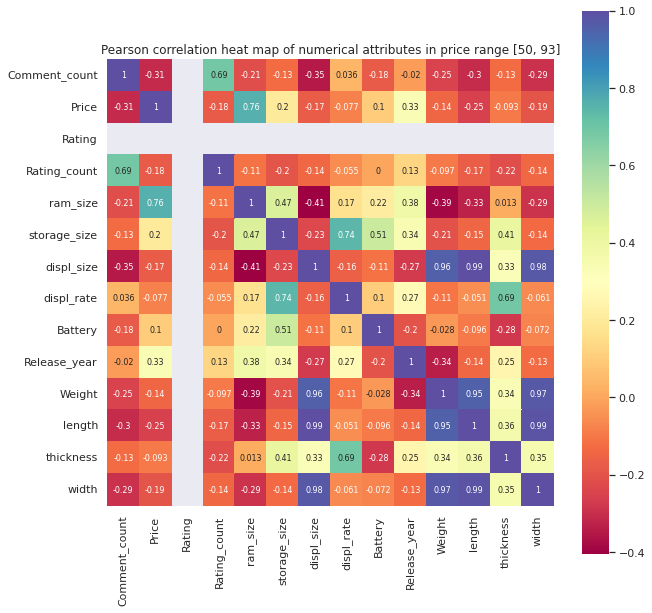

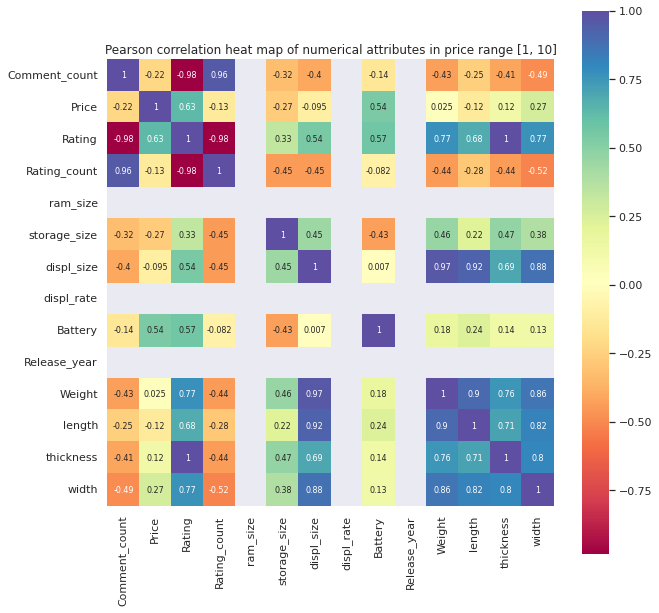

In [28]:
cols = numeric_attributes.columns
for i,df in enumerate(price_df):
    plt.figure(figsize=(10,10))
    normalize_df = (df-df.mean())/df.std()
    correlation = normalize_df.corr()
    sns.heatmap(correlation,square=True,cmap=cmap,annot=True,annot_kws = {'size':8})
        # xticklabels = cols.values ,yticklabels = cols.values, ax = ax[j], )
    plt.title("Pearson correlation heat map of numerical attributes in price range "+labels[i])
    plt.show()

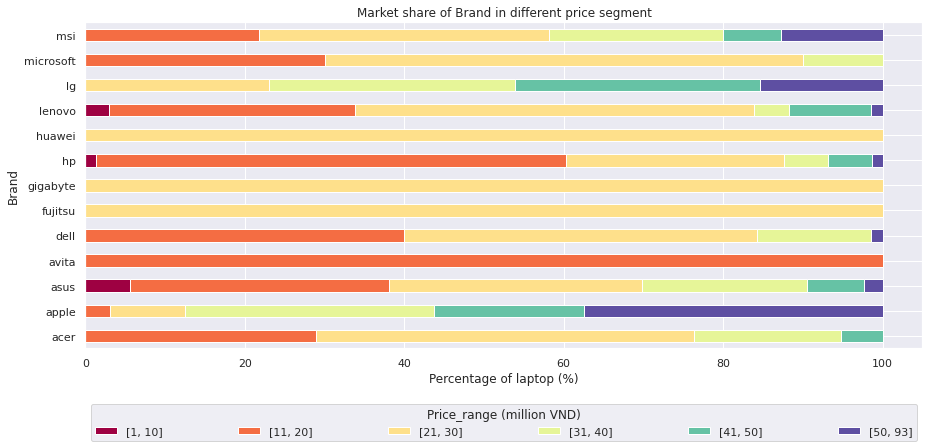

In [29]:
main_data.groupby('Brand')['Price_range'].value_counts().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().reindex(
                                                     sorted(main_data['Price_range'].dropna().unique()), 
                                                     axis=1).plot(kind='barh', 
                                                                  stacked=True, figsize=(15, 6), colormap=cmap)
plt.xlabel("Percentage of laptop (%)")
plt.title("Market share of Brand in different price segment")
plt.legend(title = 'Price_range (million VND)', loc="lower left", mode = "expand", ncol=6, bbox_to_anchor=(0, -0.3, 1, 0.4))
plt.show()

### `Battery`

count    489.000000
mean      57.597546
std       26.192562
min       30.000000
25%       42.000000
50%       50.000000
75%       65.000000
max      240.000000
Name: Battery, dtype: float64


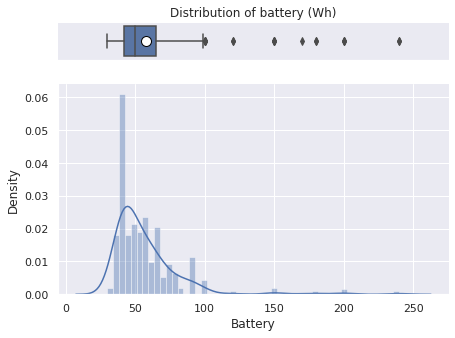

In [30]:
print(main_data.Battery.describe())
# print(main_data.Battery.value_counts())
plot_statistics(main_data.Battery,title="Distribution of battery (Wh)")

Does higher battery equivalent to higher Comment_count?

Answer: It's ambiguous. As the scatter plot below tells us, all the most popular laptop have wide variety of battery capacity

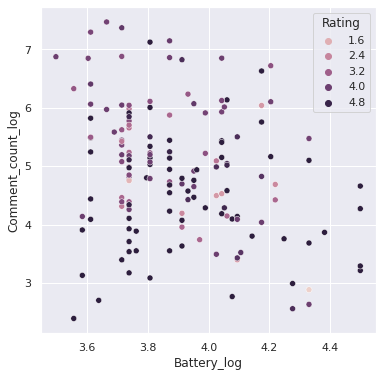

In [31]:
plt.subplots(figsize=(6, 6))
main_data['Battery_log'] = np.log(main_data['Battery'])
sns.scatterplot(x='Battery_log', y='Comment_count_log', hue='Rating', data=main_data)
# plt.ylim([0,400])
plt.show()

Does higher battery equivalent to higher Price?

Answer: Yes, as the scatter plot tells us

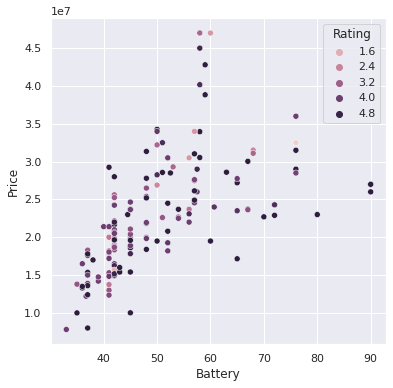

In [32]:
plt.subplots(figsize=(6, 6))
sns.scatterplot(x='Battery', y='Price', hue='Rating', data=main_data)
# plt.ylim([0,400])
plt.show()

Is display rate affects battery?

Answer: Yes, you can see in the boxplot below, the mean of Battery is increasing with the increasing direction of display rate values

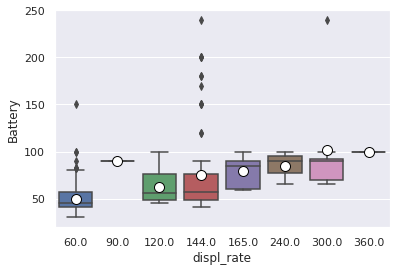

In [33]:
sns.boxplot(data=main_data,x='displ_rate',y='Battery', showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})

### Discrete numeric attributes

`displ_rate`, `displ_size`, `ram_size`, `storage_size`

We will using heatmap as well as stacked bar plot to visualize the relationship of these variable with our respond variables

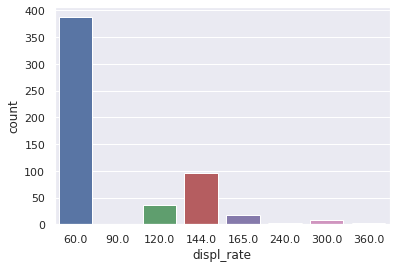

In [34]:
sns.countplot(main_data['displ_rate'].sort_values())

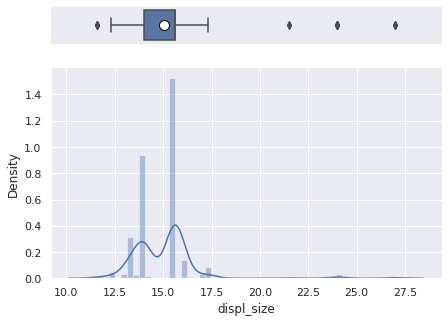

In [35]:
plot_statistics(main_data['displ_size'])

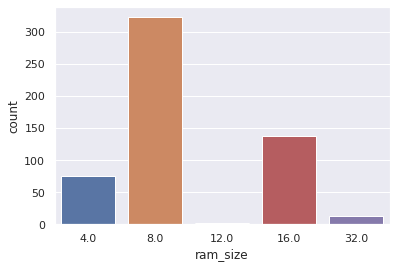

In [36]:
sns.countplot(main_data['ram_size'].sort_values())

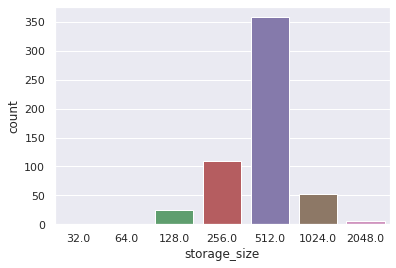

In [37]:
sns.countplot(main_data['storage_size'].sort_values())

In [38]:
main_data.groupby(['ram_size','storage_size'])['Comment_count'].mean().reset_index().pivot('ram_size','storage_size','Comment_count')

storage_size,32.0,64.0,128.0,256.0,512.0,1024.0,2048.0
ram_size,,,,,,,
4.0,NaN,21.0,115.921053,155.766667,95.523810,NaN,NaN
8.0,140.0,NaN,114.583333,185.803030,104.103239,129.000000,NaN
12.0,NaN,NaN,NaN,93.500000,NaN,NaN,NaN
16.0,NaN,NaN,NaN,45.309524,70.151852,15.358974,8.500000
32.0,NaN,NaN,NaN,NaN,NaN,2.100000,13.666667


Is higher ram_size and higher storage_size equivalent to higher Comment_count?

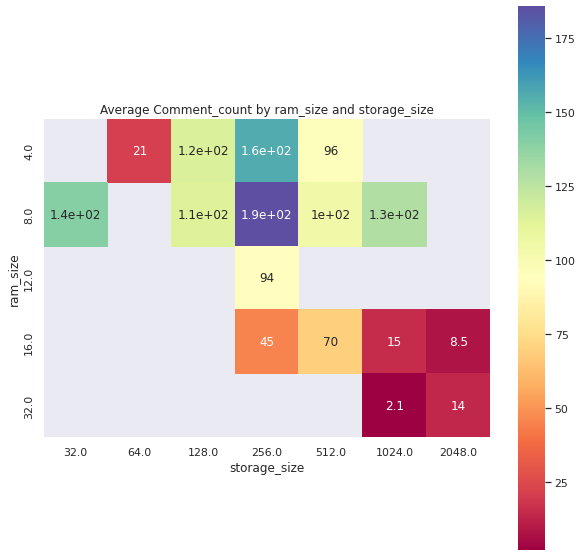

In [39]:
# sns.relplot(data=main_data, x="ram_size", y="storage_size",size="Comment_count",hue="Comment_count",palette=cmap,s=0.1,alpha=.5)
plt.figure(figsize=(10,10))
sns.heatmap(square=True,annot=True,data=main_data.groupby(['ram_size','storage_size'])['Comment_count'].mean().unstack(),cmap=cmap)
# plt.xlim([200,300])
# plt.ylim([300,400])
plt.title("Average Comment_count by ram_size and storage_size")
plt.show()

Is ram_size and storage_size influence price?

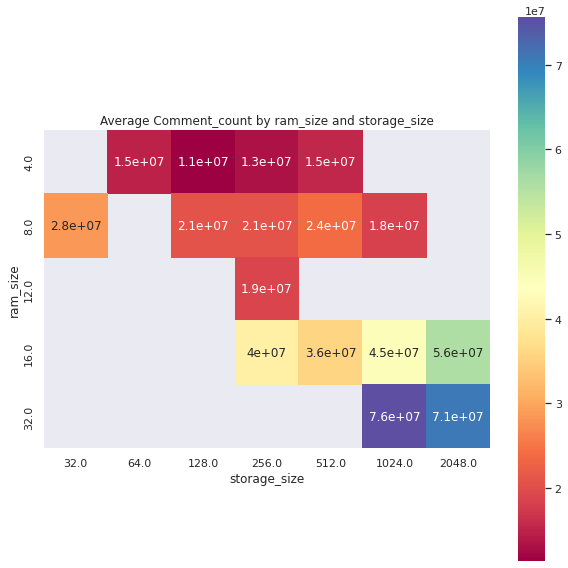

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(square=True,annot=True,data=main_data.groupby(['ram_size','storage_size'])['Price'].mean().unstack(),cmap=cmap)
# plt.xlim([200,300])
# plt.ylim([300,400])
plt.title("Average Comment_count by ram_size and storage_size")
plt.show()

### Weight and size

Is the weight and size of laptop influence the interest?

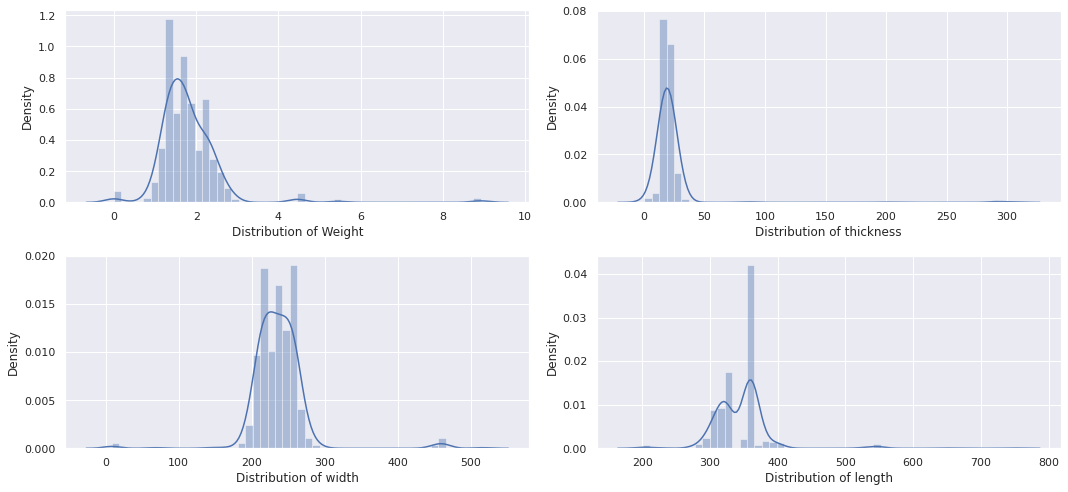

In [41]:
ncols,nrows = 2,2
spec = GridSpec(ncols=ncols, nrows=nrows)
cols = ['Weight','thickness','width','length']
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,7))
for i, att in enumerate(cols):
    plt.subplot(spec[i])
    sns.distplot(main_data[att])
    plt.xlabel('Distribution of ' + att)
plt.tight_layout()

We observed some strange behaviour such as the thickness of some laptop go beyond 200 mm, or small number of weight value is zero, which is unreasonable. These values are all outliers as we detected from the previous part. Beside of that, the distribution of 

In [42]:
def mean_normalize(series):
    return (series-series.mean())/series.std()

<Figure size 1080x1080 with 0 Axes>

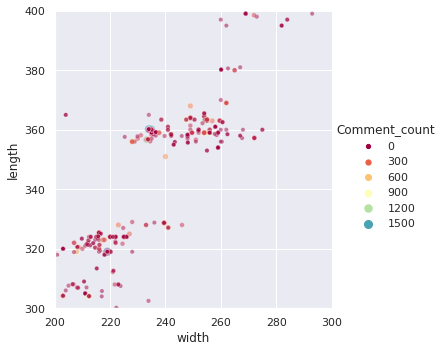

In [43]:
plt.figure(figsize=(15, 15))
sns.relplot(data=main_data, x="width", y="length",size="Comment_count",hue="Comment_count",palette=cmap,alpha=.5)
# sns.heatmap(data=main_data.pivot("width","length","Comment_count")kk)
plt.xlim([200,300])
plt.ylim([300,400])
plt.show()

(1.0, 3.0)

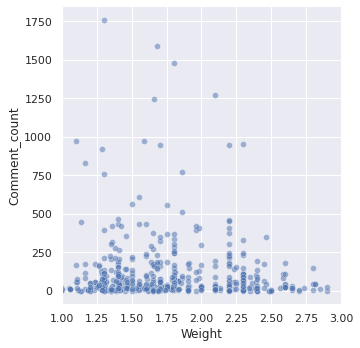

In [44]:
sns.relplot(data=main_data, x="Weight", y="Comment_count",palette=cmap,alpha=.5)
plt.xlim([1,3])

## III. Categorical analysis

---



In [46]:
def plot_cate(col_name):
    # counter = categorical_attributes[col_name].value_counts()
    # sns.barplot(counter.values, counter.index)

    sns.countplot(y=main_data[col_name].sort_values())
    plt.xlabel('Number of laptops')
    plt.ylabel(col_name)
    plt.title('Market share of ' + col_name)


def plot_boxplot(x, y):
    sns.boxplot(y=y, x=x, data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})

In [47]:
from scipy.stats import f_oneway 

def get_anova_pvalue(cate_col, num_col):
    if cate_col == 'Price_range':
        uniques = main_data[cate_col].unique()[:-1]
    else:
        uniques = main_data[cate_col].unique()
    return f_oneway(*[main_data[main_data[cate_col] == cate][num_col] for cate in uniques]).pvalue

In [48]:
from statsmodels.formula.api import ols

def t_pairwise(cate_col, num_col):

    mod = ols('{} ~ {}'.format(num_col, cate_col),
                    data=main_data).fit()

    pair_t = mod.t_test_pairwise(cate_col)
    return pair_t.result_frame

In [49]:
cate_cols = categorical_attributes.columns.to_list() + ['Price_range']
anova_pvalues = []
num_categories = []
for c in cate_cols:
    uniques = main_data[c].unique()
    num_categories.append(len(uniques) - 1 if 'NaN' in uniques or np.nan in uniques else len(uniques))

for col in cate_cols:
    anova_pvalues.append(get_anova_pvalue(col, 'Comment_count'))

cate_cols = ['GPU', 'Brand', 'CPU brand', 'CPU code', 'OS', 'Display resolution', 'Support HDMI', 'Body material', 'Support backlit keyboard', 'Support LAN', 'RAM upgradable', 'Screen technology', 'Support SD card', 'Support extra storage slot', 'Storage type', 'Support headphone jack', 'Support Type-C', 'Support USB-A', 'GPU brand', 'Price range']

summary_table = pd.DataFrame({'Analysis variable': cate_cols, '#categories': num_categories, 'ANOVA p-value': anova_pvalues}).sort_values('ANOVA p-value')
summary_table['Reject hypothesis'] = summary_table['ANOVA p-value'] <= 0.05
summary_table

,Analysis variable,#categories,ANOVA p-value,Reject hypothesis
13,Support extra storage slot,2,9.534354e-10,True
19,Price range,6,1.136593e-06,True
8,Support backlit keyboard,2,2.817380e-06,True
7,Body material,9,1.981282e-05,True
11,Screen technology,6,7.527494e-05,True
10,RAM upgradable,2,6.555863e-04,True
14,Storage type,3,5.946819e-03,True
15,Support headphone jack,2,6.033891e-02,False
9,Support LAN,2,1.022081e-01,False
6,Support HDMI,2,1.872486e-01,False


### Brand

In [50]:
main_data.groupby('Brand')['Comment_count'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Brand,,,,,,,,
acer,48.0,169.270833,260.569234,0.0,22.000,69.00,187.875,1271.0
msi,57.0,123.222222,275.458322,0.0,15.000,29.00,90.000,1756.0
lenovo,73.0,120.753425,181.148537,0.0,11.000,60.00,163.000,1244.0
asus,149.0,94.950783,192.312947,0.0,11.000,29.00,94.500,1476.0
hp,75.0,94.891111,220.546442,0.0,10.500,30.50,80.250,1589.5
dell,77.0,93.478355,120.695415,0.0,14.000,41.00,120.500,558.0
apple,33.0,85.626263,178.356283,0.0,7.000,16.00,94.000,920.5
microsoft,11.0,59.772727,46.261952,21.0,27.000,48.00,66.500,165.5
avita,5.0,29.200000,17.796067,10.0,23.000,24.00,31.000,58.0


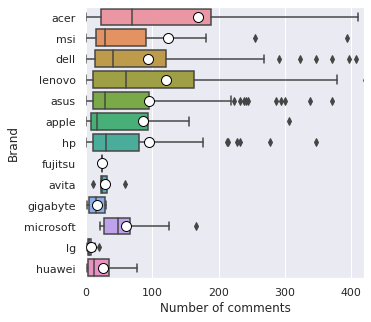

In [51]:
plt.subplots(figsize=(5, 5))
sns.boxplot(y='Brand', x="Comment_count", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
plt.xlim([-1, 420])
plt.xlabel('Number of comments')
plt.show()

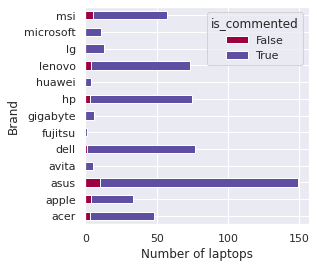

In [52]:
main_data['is_commented'] = main_data['Comment_count'] > 0
main_data.groupby('Brand')['is_commented'].value_counts().unstack().plot(kind='barh', stacked=True, figsize=(4, 4), colormap=cmap)
plt.xlabel('Number of laptops')
# plt.title('Count the number of laptops receiving comments from customers')
plt.show()

<Figure size 432x720 with 0 Axes>

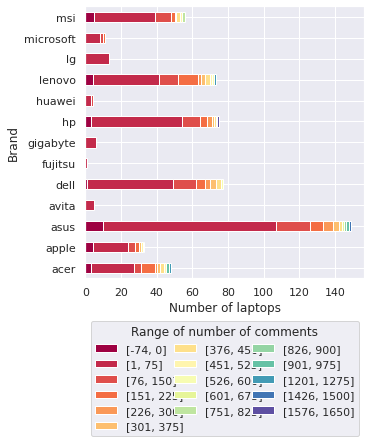

In [53]:
range_lower = list(range(-75, 1760, 75))
range_upper = list(range(0, 1760, 75))
labels = []
for i, j in zip(range_lower, range_upper):
    labels.append(str([i + 1, j]))

main_data['Comment_count_range'] = pd.cut(main_data["Comment_count"],
       bins=range_lower, 
       labels=labels)

plt.figure(figsize=(6, 10))
main_data.groupby('Brand')['Comment_count_range'].value_counts().unstack().plot(kind='barh', stacked=True, figsize=(5, 5), colormap=cmap)
#.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
plt.xlabel('Number of laptops')
# plt.title('Comment count of laptops by brand')
plt.legend(title = 'Range of number of comments', loc="lower left", mode = "expand", ncol=3, bbox_to_anchor=(0, -0.6, 1, 0.4))
plt.show()

In [54]:
brand_count = main_data.groupby('Brand')['Comment_count'].count()

for least in [0, 10, 20, 30, 40, 50, 60, 70]:
    print(least, ":", f_oneway(*[main_data[main_data['Brand'] == cate]['Comment_count'] for cate in brand_count[brand_count > least].index]).pvalue)

0 : 0.32841119696114435
10 : 0.22048744479200863
20 : 0.35676449832084084
30 : 0.35676449832084084
40 : 0.29613182437667634
50 : 0.7866762509090945
60 : 0.7548283403379874
70 : 0.7548283403379874


In [55]:
pd.set_option('display.max_rows', 14)
t_pairwise('Brand', 'Comment_count')[['pvalue-hs', 'reject-hs']].reset_index().rename(columns={'pvalue-hs': 'T-t pvalue', 'reject-hs': 'Reject hs', 'index': 'Pairs of brand'} )

,Pairs of brand,T-t pvalue,Reject hs
0,apple-acer,0.989765,False
1,asus-acer,0.843240,False
2,avita-acer,0.999933,False
3,dell-acer,0.944806,False
4,fujitsu-acer,1.000000,False
...,...,...,...
73,microsoft-lenovo,1.000000,False
74,msi-lenovo,1.000000,False
75,microsoft-lg,1.000000,False
76,msi-lg,0.985958,False


In [56]:
main_data['cpu_brand'].unique()

array(['intel', 'amd', 'apple'], dtype=object)

### Price range

In [57]:
t_pairwise('Price_range', "Comment_count").sort_values('pvalue-hs')[['pvalue-hs', 'reject-hs']].reset_index().rename(columns={'pvalue-hs': 'T-t pvalue', 'reject-hs': 'Reject hs', 'index': 'Pairs (million dongs)'} ).iloc[1:4]

,Pairs (million dongs),T-t pvalue,Reject hs
1,"[31, 40]-[11, 20]",0.000174,True
2,"[41, 50]-[11, 20]",0.000910,True
3,"[50, 93]-[11, 20]",0.003611,True


In [58]:
main_data.groupby('Price_range').count()['Comment_count'].reset_index().rename(columns={'Comment_count': 'Number of laptops'}).iloc[1:]

,Price_range,Number of laptops
1,"[1, 10]",10
2,"[11, 20]",164
3,"[21, 30]",182
4,"[31, 40]",77
5,"[41, 50]",36
6,"[50, 93]",27


In [59]:
main_data.groupby('Price_range').agg({'Brand':'count', 'Comment_count':'mean'}).reset_index().rename(columns={'Brand': 'Number of laptops', 'Price_range': 'Price range', 'Comment_count': 'Average #comments'}).iloc[1:]

,Price range,Number of laptops,Average #comments
1,"[1, 10]",10,157.400000
2,"[11, 20]",164,171.618902
3,"[21, 30]",182,109.256410
4,"[31, 40]",77,47.259740
5,"[41, 50]",36,20.402778
6,"[50, 93]",27,15.796296


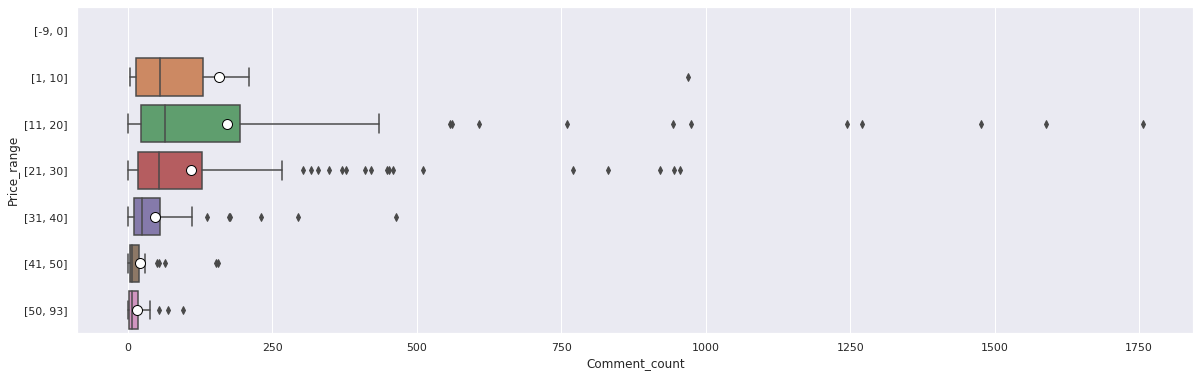

In [60]:
plt.subplots(figsize=(20, 6))
sns.boxplot(y='Price_range', x="Comment_count", data=main_data, showmeans=True, meanprops={"marker":"o", 
                                                                    "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black",
                                                                    "markersize":"10"})
# plt.xlim([-1, 420])
plt.show()

In [61]:
get_anova_pvalue('Price_range', 'Rating_count')

0.01460983867988182

In [62]:
main_data[main_data['Rating_count'] > 0].groupby('Price_range')['Rating_count'].count()

Price_range
[-9, 0]      0
[1, 10]      4
[11, 20]    61
[21, 30]    66
[31, 40]    19
[41, 50]     6
[50, 93]     1
Name: Rating_count, dtype: int64

### `Surface`

In [63]:
t_pairwise('Surface', 'Comment_count')

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
"aluminum, carbon, magnesium-aluminum",-33.740385,167.395149,-0.201561,0.840373,-362.929442,295.448673,1.000000,False
"aluminum, magnesium-aluminum",-12.740385,167.395149,-0.076110,0.939374,-341.929442,316.448673,1.000000,False
carbon-aluminum,-40.240385,234.530280,-0.171579,0.863865,-501.453282,420.972513,1.000000,False
"carbon, magnesium-aluminum",-89.540385,108.771073,-0.823200,0.410936,-303.442921,124.362152,0.999999,False
magnesium-aluminum,-24.240385,137.937295,-0.175735,0.860601,-295.499428,247.018659,1.000000,False
...,...,...,...,...,...,...,...,...
"metal, plastic-magnesium",123.460784,139.914729,0.882400,0.378146,-151.686960,398.608529,0.999999,False
plastic-magnesium,60.343696,135.161005,0.446458,0.655533,-205.455666,326.143058,1.000000,False
"metal, plastic-metal",35.673864,47.648461,0.748689,0.454531,-58.028683,129.376412,1.000000,False
plastic-metal,-27.443224,31.028081,-0.884464,0.377033,-88.461148,33.574701,0.999999,False


### `backlit_keyboard`

In [64]:
t_pairwise('backlit_keyboard', 'Comment_count')

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
yes-no,-55.164264,26.095843,-2.11391,0.03511,-106.45864,-3.869889,0.03511,True


In [65]:
main_data.groupby('backlit_keyboard')['Comment_count'].count()

backlit_keyboard
NaN    129
no      90
yes    333
Name: Comment_count, dtype: int64

###`ram_upgradable`

In [66]:
t_pairwise('ram_upgradable', 'Comment_count')

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
yes-no,58.533811,23.261569,2.516331,0.012176,12.829312,104.238311,0.012176,True


In [67]:
main_data.groupby('ram_upgradable')['Comment_count'].mean()

ram_upgradable
NaN     34.830508
no      63.270408
yes    121.804219
Name: Comment_count, dtype: float64

### `screen_technology`

In [68]:
t_pairwise('screen_technology', 'Comment_count')

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
ips-fhd,44.463746,123.424864,0.360250,0.718831,-198.104276,287.031768,0.999506,False
led-fhd,178.381720,128.677327,1.386272,0.166358,-74.509017,431.272458,0.864863,False
oled-fhd,19.676471,133.270479,0.147643,0.882691,-242.241229,281.594170,0.999506,False
tn-fhd,-33.166667,134.596586,-0.246415,0.805474,-297.690577,231.357243,0.999506,False
va-fhd,36.895062,126.236216,0.292270,0.770216,-211.198137,284.988260,0.999506,False
...,...,...,...,...,...,...,...,...
tn-led,-211.548387,66.935496,-3.160481,0.001683,-343.097335,-79.999440,0.023300,True
va-led,-141.486659,47.955209,-2.950392,0.003341,-235.733472,-47.239846,0.042575,True
tn-oled,-52.843137,75.389167,-0.700938,0.483708,-201.006163,95.319888,0.994951,False
va-oled,17.218591,59.185031,0.290928,0.771242,-99.098296,133.535478,0.999506,False


In [69]:
main_data.groupby('screen_technology')['Comment_count'].count()

screen_technology
NaN     101
fhd       3
ips     331
led      31
oled     17
tn       15
va       54
Name: Comment_count, dtype: int64

### `storage_extra_slot`

In [70]:
t_pairwise('storage_extra_slot', 'Comment_count')

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
yes-no,-17.734821,29.889756,-0.593341,0.553368,-76.538001,41.06836,0.553368,False


In [71]:
main_data.groupby('storage_extra_slot')['Comment_count'].count()

storage_extra_slot
NaN    227
no      95
yes    230
Name: Comment_count, dtype: int64

### `storage_type`

In [72]:
t_pairwise('storage_type', 'Comment_count')

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
hdd-emmc,-569.00000,241.083819,-2.360175,0.018620,-1042.573118,-95.426882,0.036893,True
ssd-emmc,-488.28198,139.446379,-3.501575,0.000501,-762.203544,-214.360417,0.001501,True
ssd-hdd,80.71802,197.025621,0.409683,0.682200,-306.309355,467.745395,0.682200,False


In [73]:
main_data[main_data['storage_type'] == 'emmc']

,GPU,Comment_count,Price,Rating,Rating_count,Brand,cpu_brand,cpu_code,ram_size,storage_size,displ_size,displ_rate,Battery,OS,displ_resolution,hdmi,Release_year,Surface,Weight,backlit_keyboard,lan,length,ram_upgradable,screen_technology,sd_card,storage_extra_slot,storage_type,headphone_jack,thickness,type_c,usb_a,width,GPU_brand,Comment_count_log,Rating_count_log,Price_range,Battery_log,is_commented,Comment_count_range
50,intel uhd graphics,209.0,9999000.0,5.0,2.0,asus,intel,n4500,4.0,128.0,11.6,60.0,45.0,windows 10,1366 x 768,yes,2021.0,plastic,1.35,yes,yes,296.9,yes,led,no,yes,emmc,yes,20.0,yes,yes,204.7,intel,5.342334,0.693147,"[1, 10]",3.806662,True,"[151, 225]"
51,intel uhd graphics 600,969.0,7799000.0,4.0,6.0,asus,intel,n4500,4.0,128.0,11.6,60.0,33.0,windows 10,1366 x 768,yes,2021.0,plastic,1.10,yes,yes,280.5,yes,led,yes,yes,emmc,yes,16.9,yes,yes,189.0,intel,6.876265,1.791759,"[1, 10]",3.496508,True,"[901, 975]"


### Pearson correlation test

[Text(0, 0, 'Brand'),
 Text(0, 0, 'cpu_brand'),
 Text(0, 0, 'OS'),
 Text(0, 0, 'displ_resolution'),
 Text(0, 0, 'hdmi'),
 Text(0, 0, 'Surface'),
 Text(0, 0, 'backlit_keyboard'),
 Text(0, 0, 'lan'),
 Text(0, 0, 'ram_upgradable'),
 Text(0, 0, 'screen_technology'),
 Text(0, 0, 'sd_card'),
 Text(0, 0, 'storage_extra_slot'),
 Text(0, 0, 'storage_type'),
 Text(0, 0, 'headphone_jack'),
 Text(0, 0, 'type_c'),
 Text(0, 0, 'usb_a'),
 Text(0, 0, 'GPU_brand')]

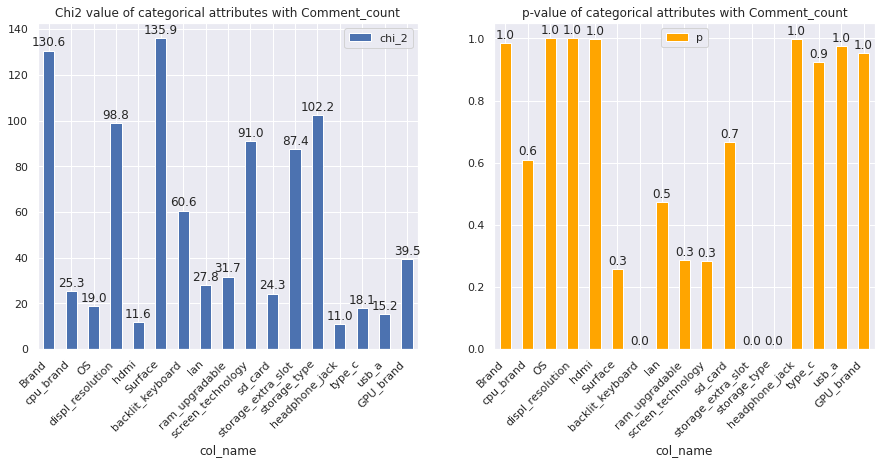

In [74]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=main_data['Comment_count'].round(-2), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2,p])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Comment_count')
ax2.set_title('p-value of categorical attributes with Comment_count')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

[Text(0, 0, 'Brand'),
 Text(0, 0, 'cpu_brand'),
 Text(0, 0, 'OS'),
 Text(0, 0, 'displ_resolution'),
 Text(0, 0, 'hdmi'),
 Text(0, 0, 'Surface'),
 Text(0, 0, 'backlit_keyboard'),
 Text(0, 0, 'lan'),
 Text(0, 0, 'ram_upgradable'),
 Text(0, 0, 'screen_technology'),
 Text(0, 0, 'sd_card'),
 Text(0, 0, 'storage_extra_slot'),
 Text(0, 0, 'storage_type'),
 Text(0, 0, 'headphone_jack'),
 Text(0, 0, 'type_c'),
 Text(0, 0, 'usb_a'),
 Text(0, 0, 'GPU_brand')]

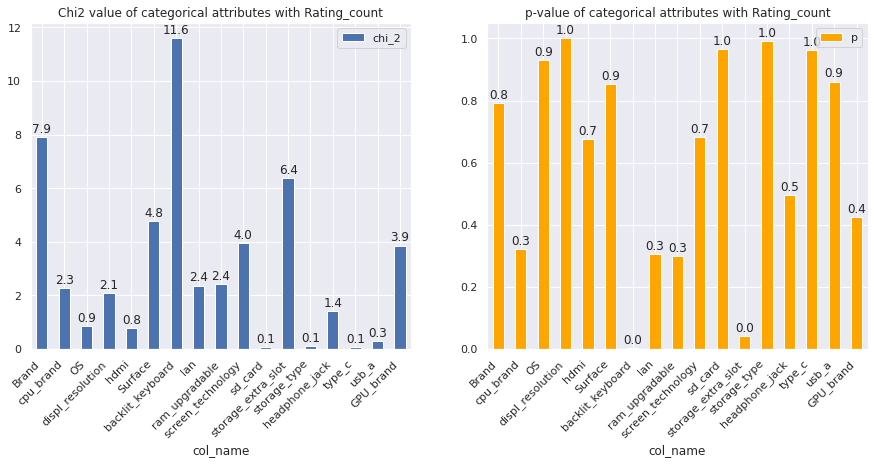

In [75]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=main_data['Rating_count'].round(-2), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2,p])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Rating_count')
ax2.set_title('p-value of categorical attributes with Rating_count')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

[Text(0, 0, 'Brand'),
 Text(0, 0, 'cpu_brand'),
 Text(0, 0, 'OS'),
 Text(0, 0, 'displ_resolution'),
 Text(0, 0, 'hdmi'),
 Text(0, 0, 'Surface'),
 Text(0, 0, 'backlit_keyboard'),
 Text(0, 0, 'lan'),
 Text(0, 0, 'ram_upgradable'),
 Text(0, 0, 'screen_technology'),
 Text(0, 0, 'sd_card'),
 Text(0, 0, 'storage_extra_slot'),
 Text(0, 0, 'storage_type'),
 Text(0, 0, 'headphone_jack'),
 Text(0, 0, 'type_c'),
 Text(0, 0, 'usb_a'),
 Text(0, 0, 'GPU_brand')]

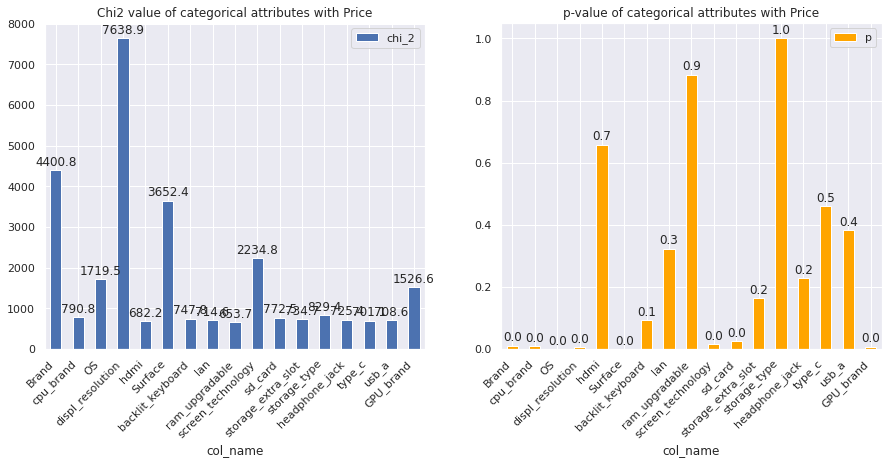

In [76]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=main_data['Price'].round(-2), columns = main_data[att])
    chi2, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2,p])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Price')
ax2.set_title('p-value of categorical attributes with Price')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

## IV. Top 10% Analysis ##
As the aforementioned, the distribution of *Comment_count* and *Rating_count* witness spectacular numbers in these stats of some product. This phenomenom leads to the question why these products are more concerned than the rest and what features that make them outperformed. 

To solve the quest, we will extract out some of the products with highest *Comment_count* and *Rating_count* - two attributes that, again, representing *popularity* and *asasas* respectively.

---

### 1. Extract the focusing products: ###

In [77]:
highest_comment_count = main_data.nlargest(50, 'Comment_count')
rest_comment_count = main_data.drop(highest_comment_count.index)
highest_comment_count.describe()

,Comment_count,Price,Rating,Rating_count,ram_size,storage_size,displ_size,displ_rate,Battery,Release_year,Weight,length,thickness,width,Comment_count_log,Rating_count_log,Battery_log
count,50.000000,5.000000e+01,42.000000,50.000000,50.000000,50.00000,50.000000,50.000000,49.000000,50.000000,50.000000,50.000000,49.000000,50.00000,50.000000,50.000000,49.000000
mean,590.846667,2.012414e+07,3.948644,18.906667,8.480000,419.84000,14.834000,79.680000,55.493878,2020.580000,1.714800,343.179800,19.182653,234.38160,6.237506,-inf,3.933430
std,366.200315,5.384039e+06,0.711171,26.308310,3.394113,159.49504,1.000329,35.528339,30.749386,0.702474,0.345304,22.322678,3.562150,17.22017,0.509758,NaN,0.360589
min,277.500000,7.799000e+06,2.000000,0.000000,4.000000,128.00000,11.600000,60.000000,33.000000,2017.000000,1.100000,280.500000,4.100000,189.00000,5.625821,-inf,3.496508
25%,349.875000,1.645588e+07,3.587500,1.500000,8.000000,256.00000,14.000000,60.000000,41.000000,2020.000000,1.406500,324.250000,17.900000,220.00000,5.857507,0.389048,3.713572
50%,427.083333,1.912933e+07,3.935285,7.333333,8.000000,512.00000,15.600000,60.000000,45.000000,2021.000000,1.700000,356.735000,19.900000,235.00000,6.056947,1.991396,3.806662
75%,767.250000,2.359450e+07,4.200000,24.333333,8.000000,512.00000,15.600000,60.000000,57.000000,2021.000000,1.960000,360.200000,19.900000,249.00000,6.642793,3.190677,4.043051
max,1756.000000,3.394950e+07,5.000000,126.000000,16.000000,1024.00000,16.100000,144.000000,200.000000,2021.000000,2.460000,369.000000,24.900000,262.00000,7.470794,4.836282,5.298317


In [78]:
highest_rating_count = main_data.nlargest(50, 'Rating_count')
rest_rating_count = main_data.drop(highest_rating_count.index)
highest_rating_count.describe()

,Comment_count,Price,Rating,Rating_count,ram_size,storage_size,displ_size,displ_rate,Battery,Release_year,Weight,length,thickness,width,Comment_count_log,Rating_count_log,Battery_log
count,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.0000,48.000000,48.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,48.000000
mean,448.910000,2.126192e+07,3.790581,23.676667,8.400000,442.880000,14.724000,79.2000,46.139583,2020.479167,1.676006,339.602600,18.971800,231.902800,5.748884,2.795354,3.815396
std,410.446243,7.165214e+06,0.549846,24.385077,3.452299,149.025767,1.144385,34.7962,8.899026,0.504852,0.378149,26.558572,4.145101,18.422124,0.862372,0.817660,0.177816
min,44.000000,7.799000e+06,2.600000,5.333333,4.000000,128.000000,11.600000,60.0000,33.000000,2020.000000,1.100000,280.500000,4.100000,189.000000,3.784190,1.673976,3.496508
25%,181.125000,1.766612e+07,3.532058,8.625000,8.000000,256.000000,14.000000,60.0000,41.000000,2020.000000,1.382500,321.775000,17.900000,216.650000,5.199187,2.154356,3.713572
50%,295.833333,2.019000e+07,3.900000,12.750000,8.000000,512.000000,14.800000,60.0000,42.000000,2020.000000,1.620000,339.850000,18.050000,234.000000,5.689663,2.545339,3.737670
75%,496.000000,2.367408e+07,4.000000,27.250000,8.000000,512.000000,15.600000,60.0000,50.250000,2021.000000,1.845000,359.000000,19.900000,247.875000,6.205144,3.303872,3.916974
max,1756.000000,4.699900e+07,5.000000,126.000000,16.000000,1024.000000,17.300000,144.0000,76.000000,2021.000000,2.600000,399.000000,28.000000,272.000000,7.470794,4.836282,4.330733


Before getting closer and clearer to our top 50, let's point out some basic statistics of these 2 lists:

Stats     | Highest Comment count  | Highest Rating count 
--------- | -------------------|------------------
Min - Max  | 277 - 1756 | 5 - 126
Mean | 590.8 | 23.67
Average Price      | 20.124.000 vnd (~ 1000USD)       | 21.261.000 vnd (~ 1050USD)
Max Price | 33.949.000 vnd (~ 1500 USD) | 46.999.000 vnd (~ 2000 USD)

At first glance, we can deduce that most of the concerned laptop based on the number of comments and ratings stay in the low-to-medium price range. No high-end product appears in the top 10%.

Let's visualize the distribution ratio as well as correlation calculation for further exploration.

### 2. Numerical attributes visualization ###

#### Continuous Numeric ####

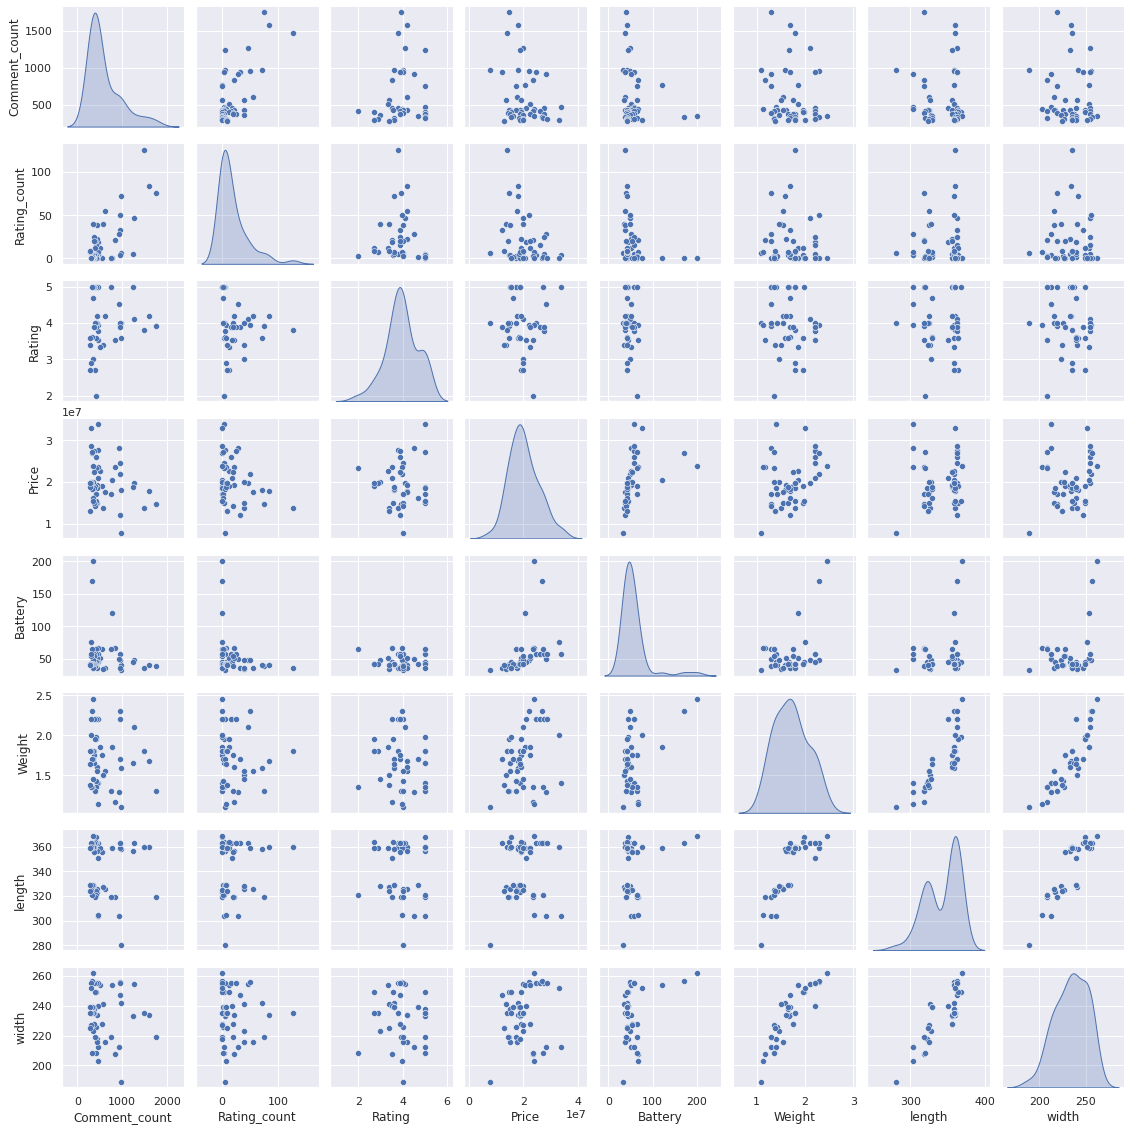

In [79]:
cols = ['Comment_count','Rating_count', 'Rating', 'Price', 'Battery', 'Weight', 'length', 'width']
sns.pairplot(highest_comment_count[cols],size = 2 ,kind ='scatter',diag_kind='kde')

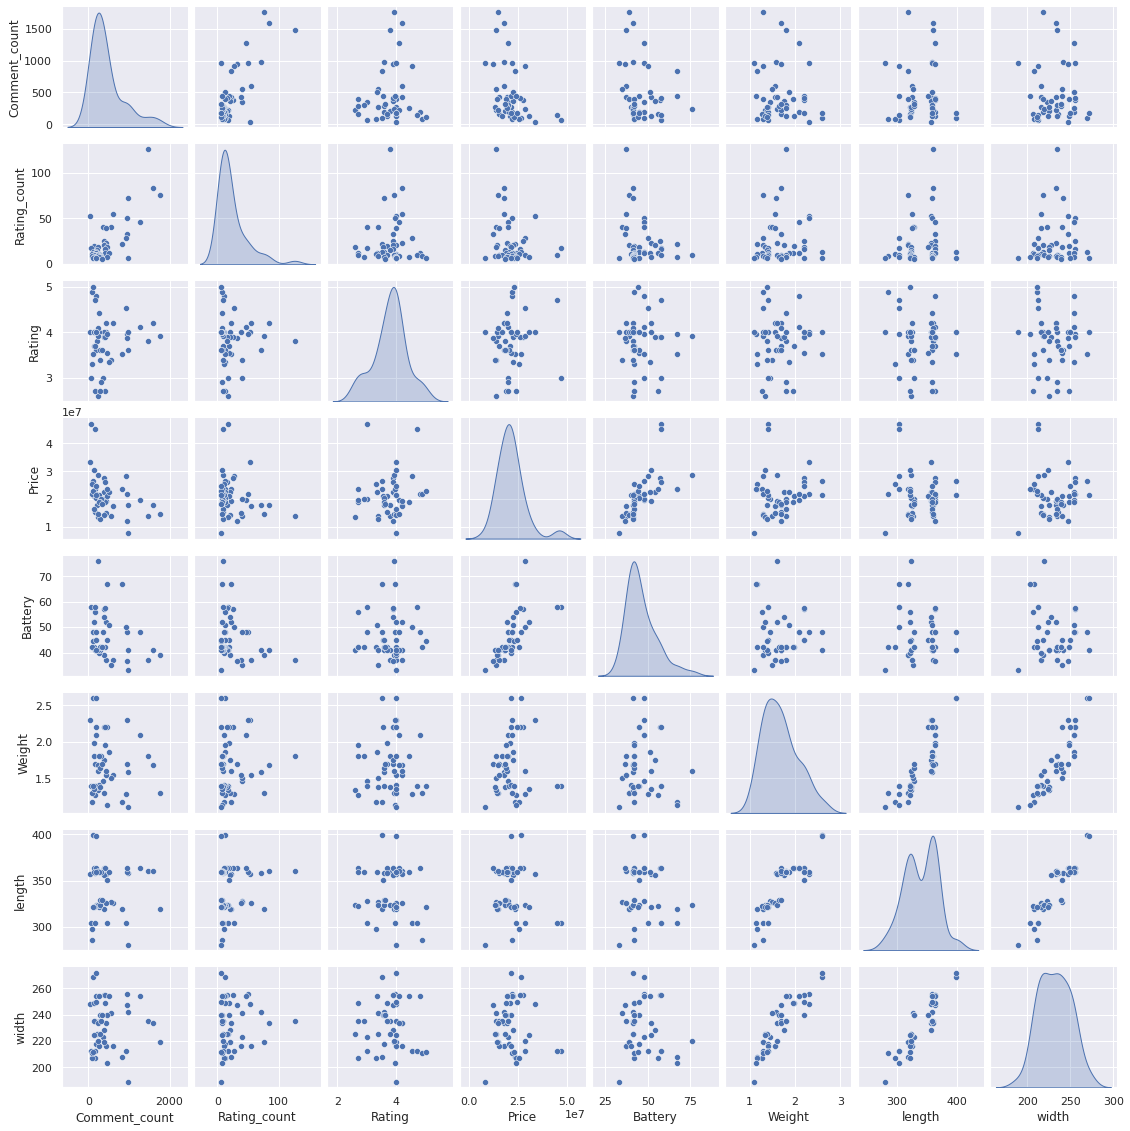

In [80]:
sns.pairplot(highest_rating_count[cols],size = 2 ,kind ='scatter',diag_kind='kde')

Text(0.5, 0.98, 'Price and Rating Count, Comment Count')

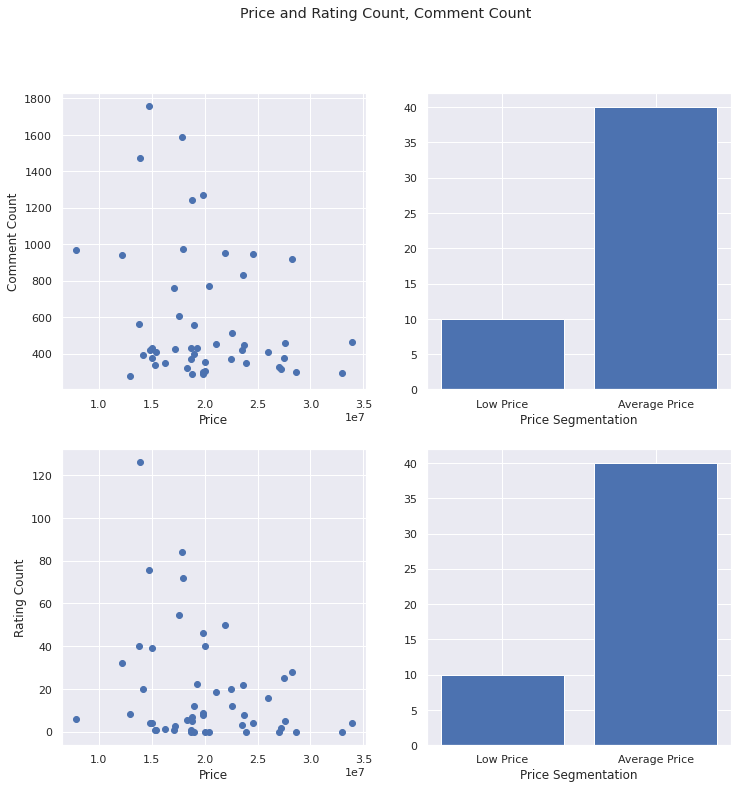

In [81]:
y = highest_comment_count['Comment_count']
x = highest_comment_count['Price']
vl_count = [len(x[x < 15000000]), len(x[x > 15000000])]
fig, ax = plt.subplots(2, 2, figsize = (12,12))
ax[0,0].scatter(x, y)
ax[0,0].set_xlabel('Price')
ax[0,0].set_ylabel('Comment Count')
ax[0,1].bar(['Low Price', 'Average Price'] ,vl_count)
ax[0,1].set_xlabel('Price Segmentation')
y = highest_comment_count['Rating_count']
x = highest_comment_count['Price']
vl_count = [len(x[x < 15000000]), len(x[x > 15000000])]
# xlabel : price
# ylabel: rating_count
ax[1,0].scatter(x, y)
ax[1,1].bar(['Low Price', 'Average Price'] ,vl_count)
ax[1,0].set_xlabel('Price')
ax[1,0].set_ylabel('Rating Count')
ax[1,1].set_xlabel('Price Segmentation')
fig.suptitle('Price and Rating Count, Comment Count')

<BarContainer object of 2 artists>

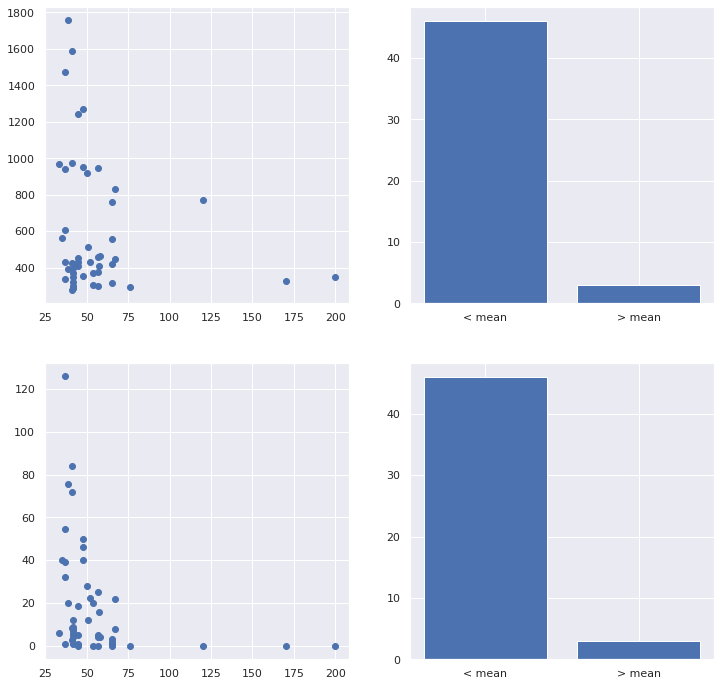

In [82]:
y = highest_comment_count['Comment_count']
x = highest_comment_count['Battery']
vl_count = [len(x[x < (x.min() + x.max())/2]), len(x[x > (x.min() + x.max())/2])]
fig, ax = plt.subplots(2, 2, figsize = (12,12))
ax[0,0].scatter(x, y)
ax[0,1].bar(['< mean', '> mean'] ,vl_count)

y = highest_comment_count['Rating_count']
x = highest_comment_count['Battery']
vl_count = [len(x[x < (x.min() + x.max())/2]), len(x[x > (x.min() + x.max())/2])]
ax[1,0].scatter(x, y)
ax[1,1].bar(['< mean', '> mean'] ,vl_count)

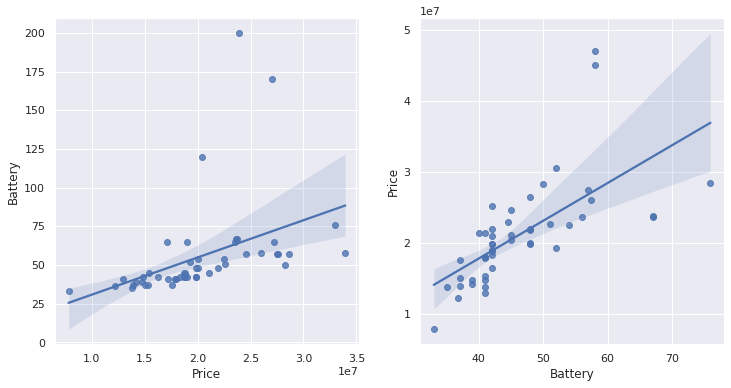

In [83]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.regplot(x="Price", y="Battery", data=highest_comment_count, ax = ax[0])
sns.regplot(y="Price", x="Battery", data=highest_rating_count, ax = ax[1])

3. Correlation index

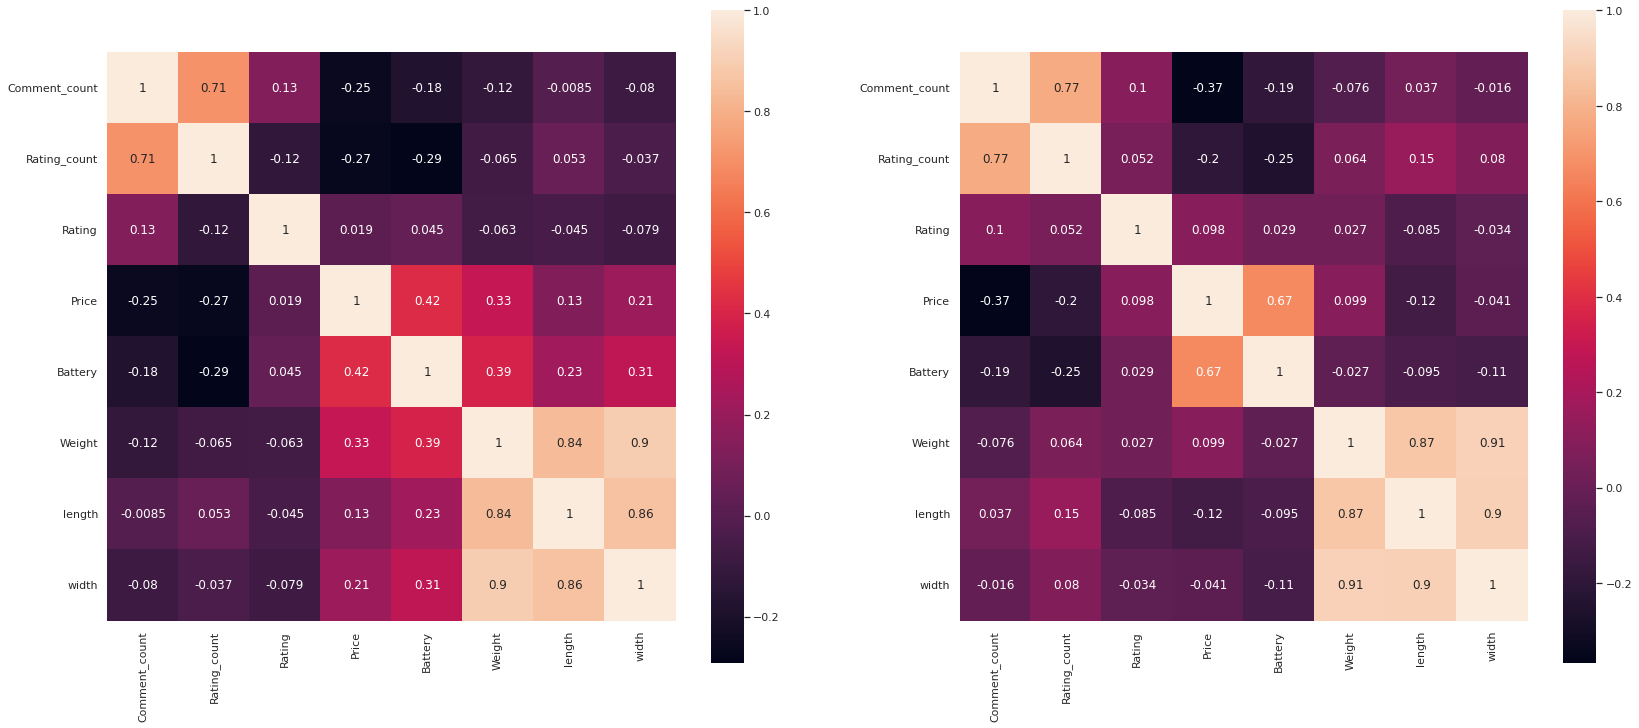

In [84]:
correlation_att = highest_comment_count[cols]
normalized_correlation_att = (correlation_att - correlation_att.mean())/correlation_att.std()
correlation = normalized_correlation_att.corr()
f , ax = plt.subplots(1,2,figsize = (28,12))
sns.heatmap(correlation, square = True, annot = True, ax = ax[0])
correlation_att = highest_rating_count[cols]
normalized_correlation_att = (correlation_att - correlation_att.mean())/correlation_att.std()
correlation = normalized_correlation_att.corr()
sns.heatmap(correlation, square = True, annot = True, ax = ax[1])

#### 3. Discrete Numeric ####

Text(0.5, 1.0, 'Release Year')

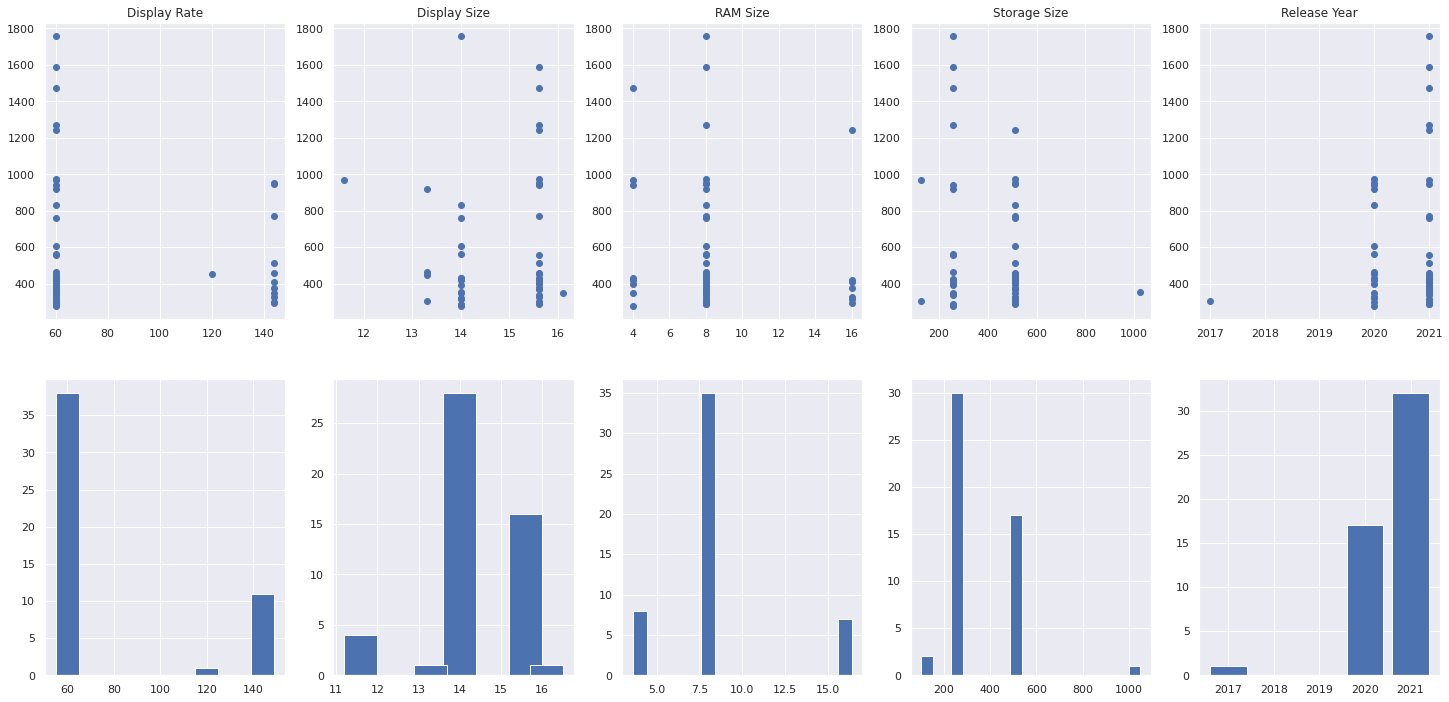

In [85]:
y = highest_comment_count['Comment_count']
x = highest_comment_count['displ_rate']
fig, ax = plt.subplots(2, 5, figsize = (25,12))
ax[0,0].scatter(x, y)
ax[1,0].bar(x.unique(), x.value_counts(), width=10 )

y = highest_comment_count['Comment_count']
x = highest_comment_count['displ_size']
ax[0,1].scatter(x, y)
ax[1,1].bar(x.unique(), x.value_counts())

y = highest_comment_count['Comment_count']
x = highest_comment_count['ram_size']
ax[0,2].scatter(x, y)
ax[1,2].bar(x.unique(), x.value_counts())

y = highest_comment_count['Comment_count']
x = highest_comment_count['storage_size']
ax[0,3].scatter(x, y)
ax[1,3].bar(x.unique(), x.value_counts(), width=50)

y = highest_comment_count['Comment_count']
x = highest_comment_count['Release_year']
ax[0,4].scatter(x, y)
ax[1,4].bar(x.unique(), x.value_counts())

ax[0,0].set_title('Display Rate')
ax[0,1].set_title('Display Size')
ax[0,2].set_title('RAM Size')
ax[0,3].set_title('Storage Size')
ax[0,4].set_title('Release Year')


<BarContainer object of 3 artists>

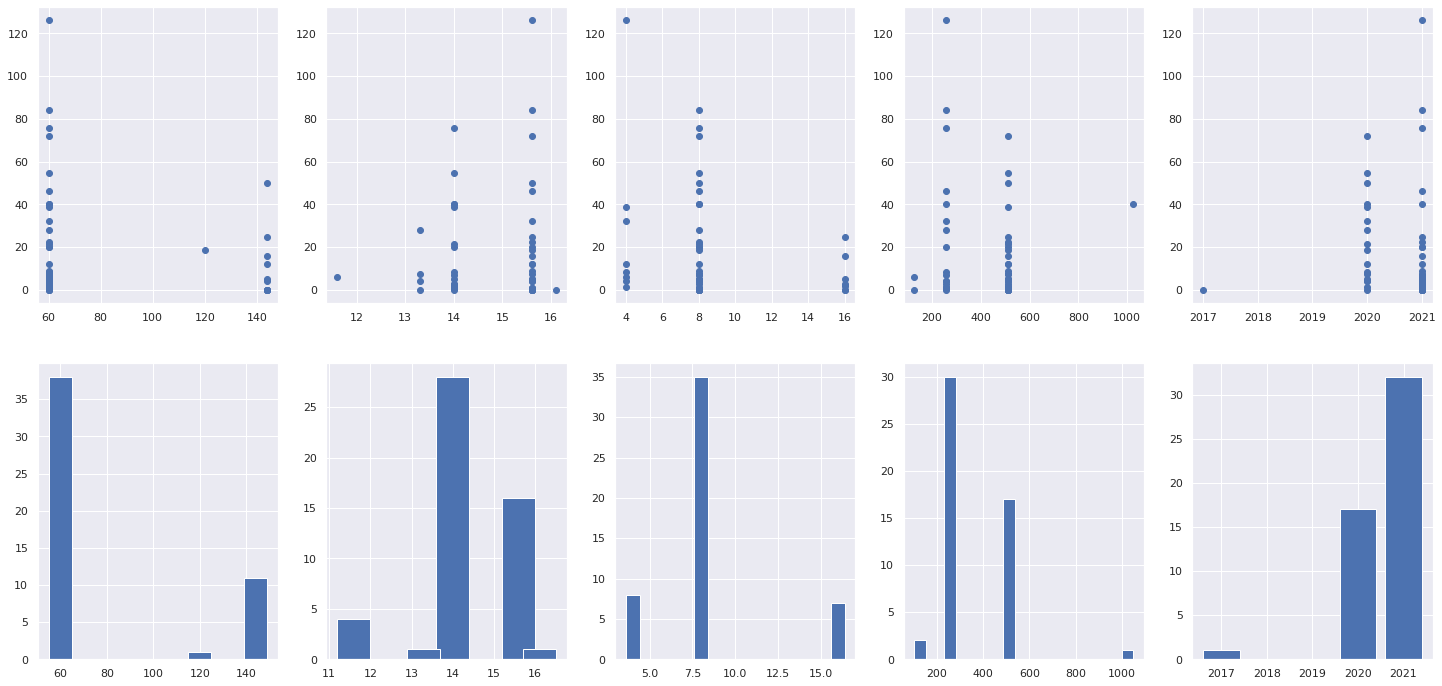

In [86]:
y = highest_comment_count['Rating_count']
x = highest_comment_count['displ_rate']
fig, ax = plt.subplots(2, 5, figsize = (25,12))
ax[0,0].scatter(x, y)
ax[1,0].bar(x.unique(), x.value_counts(), width=10)

y = highest_comment_count['Rating_count']
x = highest_comment_count['displ_size']
ax[0,1].scatter(x, y)
ax[1,1].bar(x.unique(), x.value_counts())

y = highest_comment_count['Rating_count']
x = highest_comment_count['ram_size']
ax[0,2].scatter(x, y)
ax[1,2].bar(x.unique(), x.value_counts())

y = highest_comment_count['Rating_count']
x = highest_comment_count['storage_size']
ax[0,3].scatter(x, y)
ax[1,3].bar(x.unique(), x.value_counts(), width=50)

y = highest_comment_count['Rating_count']
x = highest_comment_count['Release_year']
ax[0,4].scatter(x, y)
ax[1,4].bar(x.unique(), x.value_counts())



### Categorical attributes visualization ###


#### Brand ####

Text(0.5, 0.98, 'Brand Distribution')

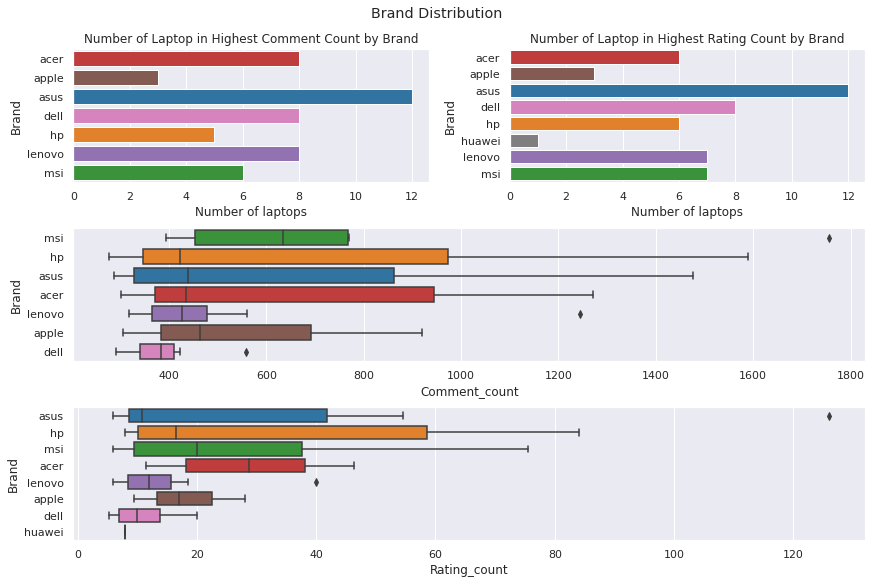

In [87]:
col_name = 'Brand'
palette_colors = sns.color_palette('tab10')
palette_dict = {brand: color for brand, color in zip(highest_rating_count[col_name].unique(), palette_colors)}

fig = plt.figure(constrained_layout=True,figsize=(12,8))
gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0:2])
ax3 = fig.add_subplot(gs[2,0:2])

sns.countplot(y=highest_comment_count[col_name].sort_values(), ax = ax0, palette=palette_dict)
ax0.set_xlabel('Number of laptops')
ax0.set_ylabel(col_name)
ax0.set_title('Number of Laptop in Highest Comment Count by Brand')

sns.countplot(y=highest_rating_count[col_name].sort_values(), ax = ax1, palette=palette_dict)
ax1.set_xlabel('Number of laptops')
ax1.set_ylabel(col_name)
ax1.set_title('Number of Laptop in Highest Rating Count by Brand')

sns.boxplot(y='Brand', x="Comment_count", data=highest_comment_count, ax = ax2, palette=palette_dict)
sns.boxplot(y='Brand', x="Rating_count", data=highest_rating_count, ax = ax3, palette=palette_dict)
fig.suptitle('Brand Distribution')

#### CPU - GPU ####

Text(0.5, 0.98, 'GPU Brand Distribution')

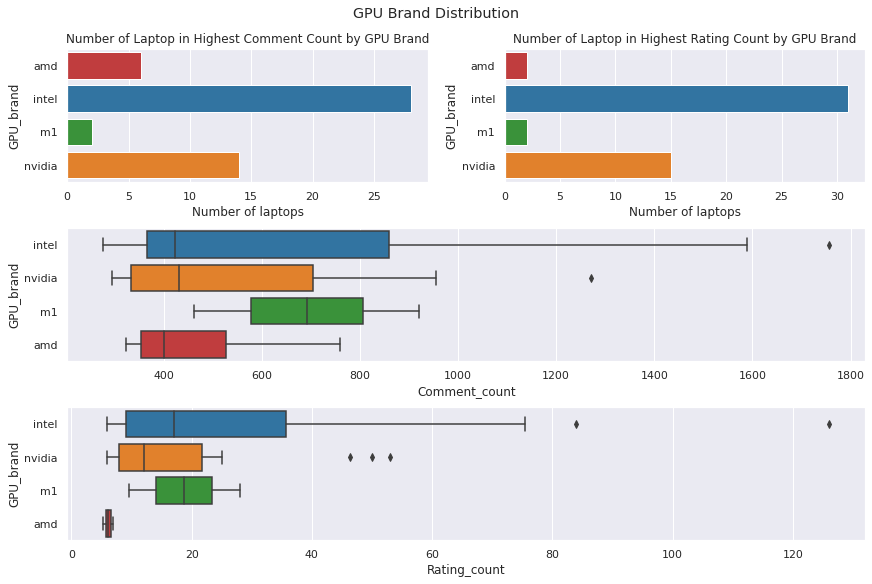

In [88]:
col_name = 'GPU_brand'
palette_colors = sns.color_palette('tab10')
palette_dict = {brand: color for brand, color in zip(highest_rating_count[col_name].unique(), palette_colors)}

fig = plt.figure(constrained_layout=True,figsize=(12,8))
gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0:2])
ax3 = fig.add_subplot(gs[2,0:2])

sns.countplot(y=highest_comment_count[col_name].sort_values(), ax = ax0, palette=palette_dict)
ax0.set_xlabel('Number of laptops')
ax0.set_ylabel(col_name)
ax0.set_title('Number of Laptop in Highest Comment Count by GPU Brand')

sns.countplot(y=highest_rating_count[col_name].sort_values(), ax = ax1, palette=palette_dict)
ax1.set_xlabel('Number of laptops')
ax1.set_ylabel(col_name)
ax1.set_title('Number of Laptop in Highest Rating Count by GPU Brand')

sns.boxplot(y='GPU_brand', x="Comment_count", data=highest_comment_count, ax = ax2, palette=palette_dict)
sns.boxplot(y='GPU_brand', x="Rating_count", data=highest_rating_count, ax = ax3, palette=palette_dict)
fig.suptitle('GPU Brand Distribution')

Text(0.5, 0.98, 'CPU Brand Distribution')

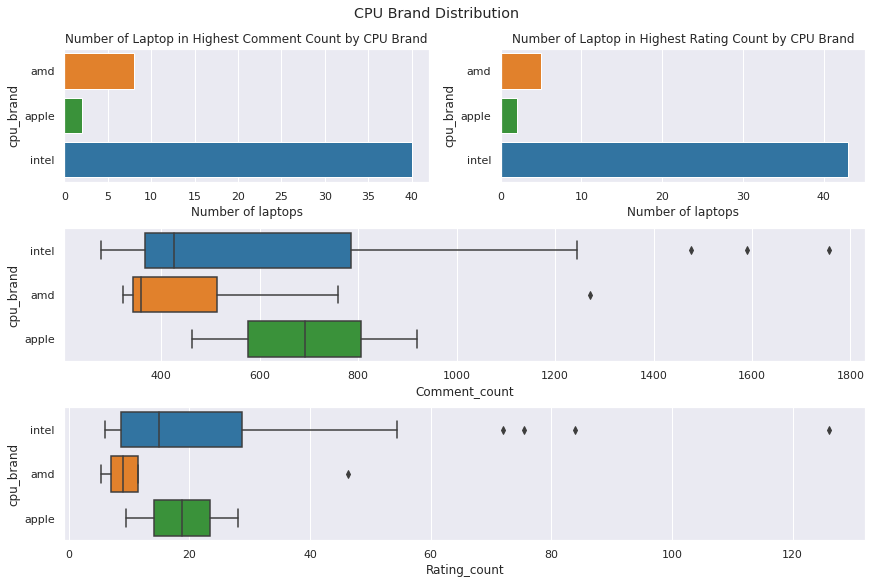

In [89]:
col_name = 'cpu_brand'
palette_colors = sns.color_palette('tab10')
palette_dict = {brand: color for brand, color in zip(highest_rating_count[col_name].unique(), palette_colors)}

fig = plt.figure(constrained_layout=True,figsize=(12,8))
gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0:2])
ax3 = fig.add_subplot(gs[2,0:2])

sns.countplot(y=highest_comment_count[col_name].sort_values(), ax = ax0, palette=palette_dict)
ax0.set_xlabel('Number of laptops')
ax0.set_ylabel(col_name)
ax0.set_title('Number of Laptop in Highest Comment Count by CPU Brand')

sns.countplot(y=highest_rating_count[col_name].sort_values(), ax = ax1, palette=palette_dict)
ax1.set_xlabel('Number of laptops')
ax1.set_ylabel(col_name)
ax1.set_title('Number of Laptop in Highest Rating Count by CPU Brand')

sns.boxplot(y='cpu_brand', x="Comment_count", data=highest_comment_count, ax = ax2, palette=palette_dict)
sns.boxplot(y='cpu_brand', x="Rating_count", data=highest_rating_count, ax = ax3, palette=palette_dict)
fig.suptitle('CPU Brand Distribution')

#### Chi square test and p-value ####

[Text(0, 0, 'Brand'),
 Text(0, 0, 'cpu_brand'),
 Text(0, 0, 'OS'),
 Text(0, 0, 'displ_resolution'),
 Text(0, 0, 'hdmi'),
 Text(0, 0, 'Surface'),
 Text(0, 0, 'backlit_keyboard'),
 Text(0, 0, 'lan'),
 Text(0, 0, 'ram_upgradable'),
 Text(0, 0, 'screen_technology'),
 Text(0, 0, 'sd_card'),
 Text(0, 0, 'storage_extra_slot'),
 Text(0, 0, 'storage_type'),
 Text(0, 0, 'headphone_jack'),
 Text(0, 0, 'type_c'),
 Text(0, 0, 'usb_a'),
 Text(0, 0, 'GPU_brand')]

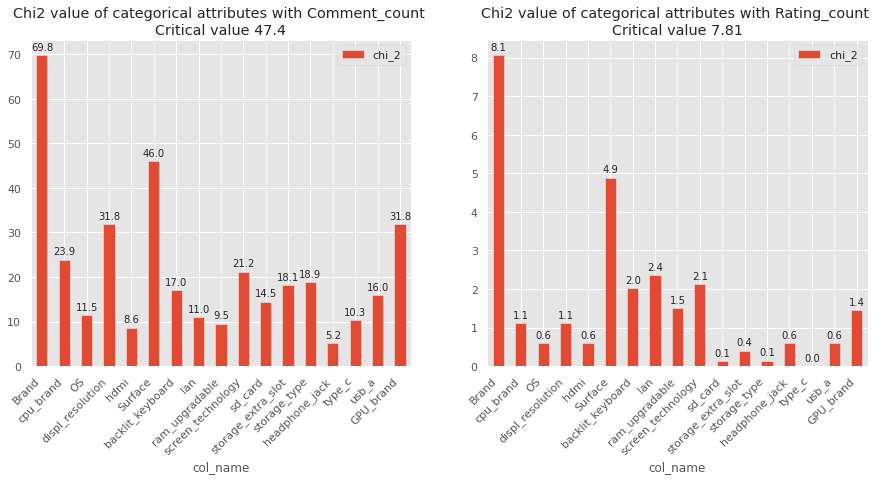

In [92]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=highest_comment_count['Comment_count'].round(-2), columns = highest_comment_count[att])
    chi2stat, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2stat,p])
critical = chi2.ppf(0.95, dof) #Tinhs critical value theo threshold 95%
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
#pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Comment_count \nCritical value {}'.format(critical.round(2)))
#ax2.set_title('p-value of categorical attributes with Rating_count')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
#ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

corr_df = []
for att in to_vis:
    obs = pd.crosstab(index=highest_rating_count['Rating_count'].round(-2), columns = highest_rating_count[att])
    chi2stat, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2stat,p])
critical = chi2.ppf(0.95, dof)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax2)
ax2.set_title('Chi2 value of categorical attributes with Rating_count \nCritical value {}'.format(critical.round(2)))
add_number(ax2,orient='v')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')

7.814727903251179


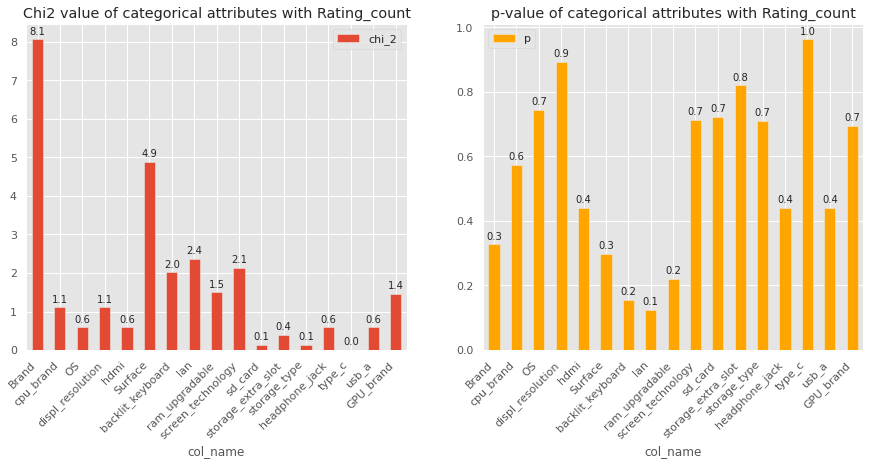

In [93]:
corr_df = []
to_vis = [c for c in categorical_attributes.columns if c not in ['GPU','cpu_code']]
for att in to_vis:
    obs = pd.crosstab(index=highest_rating_count['Rating_count'].round(-2), columns = highest_rating_count[att])
    chi2stat, p, dof, ex = chi2_contingency(obs, correction=False)
    corr_df.append([att,chi2stat,p])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='chi_2',kind='bar',ax=ax1)
pd.DataFrame(corr_df,columns=['col_name','chi_2','p']).plot(x='col_name',y='p',kind='bar',ax=ax2,color='orange')
ax1.set_title('Chi2 value of categorical attributes with Rating_count')
ax2.set_title('p-value of categorical attributes with Rating_count')
add_number(ax1,orient='v')
add_number(ax2,orient='v')
ax1.set_xticklabels(to_vis,rotation = 45,ha='right')
ax2.set_xticklabels(to_vis,rotation = 45,ha='right')
critical = chi2.ppf(0.95, dof)
print(critical)